In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tqdm opencv-python jsonlines
!pip install gdown
import os
import urllib.request
import zipfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.3 MB/s eta 0:00:00


In [3]:
!unzip /content/drive/MyDrive/inria.zip -d /content/inria/


Archive:  /content/drive/MyDrive/inria.zip
  inflating: /content/inria/Test/Annotations/crop001501.xml  
  inflating: /content/inria/Test/Annotations/crop001504.xml  
  inflating: /content/inria/Test/Annotations/crop001511.xml  
  inflating: /content/inria/Test/Annotations/crop001512.xml  
  inflating: /content/inria/Test/Annotations/crop001514.xml  
  inflating: /content/inria/Test/Annotations/crop001520.xml  
  inflating: /content/inria/Test/Annotations/crop001521.xml  
  inflating: /content/inria/Test/Annotations/crop001522.xml  
  inflating: /content/inria/Test/Annotations/crop001531.xml  
  inflating: /content/inria/Test/Annotations/crop001533.xml  
  inflating: /content/inria/Test/Annotations/crop001544.xml  
  inflating: /content/inria/Test/Annotations/crop001545.xml  
  inflating: /content/inria/Test/Annotations/crop001546.xml  
  inflating: /content/inria/Test/Annotations/crop001549.xml  
  inflating: /content/inria/Test/Annotations/crop001555.xml  
  inflating: /content/inria

In [4]:
# Section 0: Load Manually Uploaded INRIA Dataset
import os
from glob import glob
import xml.etree.ElementTree as ET

# Set base path for INRIA dataset
path = "/content/inria"

# Define paths
train_image_dir = os.path.join(path, "Train", "JPEGImages")
train_xml_dir = os.path.join(path, "Train", "Annotations")
train_label_dir = os.path.join(path, "Train", "labels")
os.makedirs(train_label_dir, exist_ok=True)

val_image_dir = os.path.join(path, "Test", "JPEGImages")
val_xml_dir = os.path.join(path, "Test", "Annotations")
val_label_dir = os.path.join(path, "Test", "labels")
os.makedirs(val_label_dir, exist_ok=True)


In [5]:
from glob import glob
import os

print("Some files in Train/JPEGImages:")
print(glob(os.path.join(train_image_dir, "*"))[:5])


Some files in Train/JPEGImages:
['/content/inria/Train/JPEGImages/crop001265.png', '/content/inria/Train/JPEGImages/crop001536.png', '/content/inria/Train/JPEGImages/person_245.png', '/content/inria/Train/JPEGImages/crop001579.png', '/content/inria/Train/JPEGImages/crop001663.png']


In [6]:
def convert_annotations(xml_dir, label_dir):
    for xml_file in glob(os.path.join(xml_dir, "*.xml")):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)
        yolo_lines = []

        for obj in root.findall("object"):
            name = obj.find("name").text
            if name != "person":
                continue
            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            ymin = float(xml_box.find("ymin").text)
            xmax = float(xml_box.find("xmax").text)
            ymax = float(xml_box.find("ymax").text)

            x_center = (xmin + xmax) / 2 / img_w
            y_center = (ymin + ymax) / 2 / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h
            yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        txt_name = os.path.basename(xml_file).replace(".xml", ".txt")
        with open(os.path.join(label_dir, txt_name), "w") as f:
            f.write("\n".join(yolo_lines))

print("Converting training annotations...")
convert_annotations(train_xml_dir, train_label_dir)
print("Converting validation annotations...")
convert_annotations(val_xml_dir, val_label_dir)

print("Train images:", len(glob(os.path.join(train_image_dir, '*.jpg'))))
print("Train labels:", len(glob(os.path.join(train_label_dir, '*.txt'))))
print("Val images:", len(glob(os.path.join(val_image_dir, '*.jpg'))))
print("Val labels:", len(glob(os.path.join(val_label_dir, '*.txt'))))


Converting training annotations...
Converting validation annotations...
Train images: 0
Train labels: 614
Val images: 0
Val labels: 288


In [7]:
import cv2
import torch
from torch.utils.data import Dataset

class INRIA_YOLO_Dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        label_names = set(os.path.basename(f).replace('.txt', '') for f in glob(os.path.join(annotation_dir, '*.txt')))
        self.image_paths = sorted([
            p for p in glob(os.path.join(image_dir, '*.*'))
            if os.path.splitext(os.path.basename(p))[0] in label_names
        ])
        self.annotation_dir = annotation_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        label_path = os.path.join(
            self.annotation_dir,
            os.path.basename(img_path).replace('.jpg', '.txt').replace('.png', '.txt')
        )
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:
                        boxes.append(parts)

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image).permute(2, 0, 1).float() / 255.0, torch.tensor(boxes)



In [8]:
from torch.utils.data import DataLoader

train_dataset = INRIA_YOLO_Dataset(
    image_dir=train_image_dir,
    annotation_dir=train_label_dir
)

val_dataset = INRIA_YOLO_Dataset(
    image_dir=val_image_dir,
    annotation_dir=val_label_dir
)

print("Train images loaded:", len(train_dataset))
print("Val images loaded:", len(val_dataset))

if len(train_dataset) == 0:
    raise ValueError("No training images found. Check the dataset path and file extensions.")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


Train images loaded: 614
Val images loaded: 288


In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00


In [10]:
os.makedirs("/content/yolo_data/train/images", exist_ok=True)
os.makedirs("/content/yolo_data/train/labels", exist_ok=True)
os.makedirs("/content/yolo_data/val/images", exist_ok=True)
os.makedirs("/content/yolo_data/val/labels", exist_ok=True)

# Copy images and labels to YOLO-compatible folders
import shutil
for src in train_dataset.image_paths:
    shutil.copy(src, "/content/yolo_data/train/images/")
for f in glob(os.path.join(train_label_dir, '*.txt')):
    shutil.copy(f, "/content/yolo_data/train/labels/")

for src in val_dataset.image_paths:
    shutil.copy(src, "/content/yolo_data/val/images/")
for f in glob(os.path.join(val_label_dir, '*.txt')):
    shutil.copy(f, "/content/yolo_data/val/labels/")

# Create YOLO data.yaml file
with open("/content/yolo_data/data.yaml", "w") as f:
    f.write("""
path: /content/yolo_data
train: train
val: val
names:
  0: person
""")



In [14]:
from ultralytics import YOLO
# Load YOLOv8 model architecture (no pretrained weights)
model = YOLO("yolov8n.yaml")

# Train the model using the data.yaml config
model.train(
    data="/content/yolo_data/data.yaml",
    epochs=50,
    imgsz=640,

)

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/yolo_data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2570.9±767.3 MB/s, size: 686.1 KB)


train: Scanning /content/yolo_data/train/labels... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:01<00:00, 404.20it/s]

train: /content/yolo_data/train/images/crop001616.png: 3 duplicate labels removed
train: New cache created: /content/yolo_data/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3132.0±980.7 MB/s, size: 533.7 KB)



val: Scanning /content/yolo_data/val/labels... 288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:00<00:00, 506.94it/s]

val: /content/yolo_data/val/images/crop001607.png: 1 duplicate labels removed
val: /content/yolo_data/val/images/person_200.png: 7 duplicate labels removed
val: New cache created: /content/yolo_data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.998      3.846      4.101         18        640: 100%|██████████| 39/39 [01:13<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.57s/it]

                   all        288        589   0.000646       0.09   0.000383   6.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      3.252      3.254      3.578         27        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

                   all        288        589   0.000234     0.0272   0.000162   2.46e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.946      3.001      3.158         44        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]

                   all        288        589     0.0959      0.134     0.0463     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.703      2.853      2.913         24        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:15<00:00,  1.74s/it]

                   all        288        589      0.194      0.188      0.109     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.482      2.634      2.734         15        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.52s/it]

                   all        288        589      0.376      0.251      0.201     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.379      2.452      2.629         27        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

                   all        288        589      0.442      0.379      0.366      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.301      2.333      2.564         22        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.518       0.43      0.448        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.162      2.216      2.451         25        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

                   all        288        589      0.443      0.503      0.435      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.079      2.116      2.385         21        640: 100%|██████████| 39/39 [01:10<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.50s/it]

                   all        288        589      0.627       0.56      0.642      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.987      1.932      2.291         27        640: 100%|██████████| 39/39 [01:10<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589       0.65      0.479       0.57      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50         0G        1.9      1.863      2.249         18        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589       0.59      0.377      0.416      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.84      1.842      2.175         30        640: 100%|██████████| 39/39 [01:10<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

                   all        288        589      0.682       0.62      0.698      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.824      1.746       2.15         29        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]

                   all        288        589      0.785      0.604       0.74      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G       1.77      1.674      2.096         16        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.819      0.637      0.755      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.736      1.699       2.05         26        640: 100%|██████████| 39/39 [01:10<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589        0.8      0.643      0.762      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G      1.708      1.645      2.033         38        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.809      0.649       0.78      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.681      1.571      1.999         33        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.875      0.693      0.833      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.646      1.556      1.961         25        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.858      0.693      0.825      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/50         0G      1.643      1.541      1.967         25        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.837      0.759      0.856       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.616      1.508      1.944         23        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]

                   all        288        589      0.865      0.745      0.849      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/50         0G      1.582      1.484      1.881         28        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589       0.89       0.75      0.877      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.556       1.44      1.871         19        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.779      0.713      0.806      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.534      1.416      1.858         37        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.909      0.793       0.89      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/50         0G      1.553      1.409      1.857         24        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.894      0.756      0.877      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G      1.544      1.416      1.829         25        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.907      0.795      0.905      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.511      1.367        1.8         21        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.887      0.801      0.897      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.504      1.374      1.778         22        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        288        589        0.9      0.811      0.897      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.504      1.355      1.758         20        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.878      0.823       0.89      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50         0G      1.464      1.352      1.748         21        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.876      0.795      0.888      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G      1.469      1.291      1.736         30        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.893      0.796       0.89      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50         0G      1.447       1.29      1.724         27        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.915      0.839      0.923      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.431      1.294      1.725         29        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.938      0.817      0.916      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.449      1.266      1.716         19        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.909      0.832      0.921      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.415      1.236      1.688         11        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.917      0.793      0.912      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50         0G      1.437      1.275      1.705         19        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        288        589      0.917      0.818      0.912      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50         0G      1.404      1.243      1.688         32        640: 100%|██████████| 39/39 [01:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.889      0.829      0.916      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50         0G      1.377      1.187      1.652         19        640: 100%|██████████| 39/39 [01:09<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.906      0.856      0.922      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.378      1.214      1.649         24        640: 100%|██████████| 39/39 [01:09<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        288        589      0.917      0.848       0.93      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.344      1.198      1.634         31        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.932      0.835      0.923      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.363      1.197      1.661         23        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589        0.9      0.839      0.922      0.587
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      41/50         0G      1.235      1.109      1.544          9        640: 100%|██████████| 39/39 [01:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        288        589      0.878      0.819      0.904      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      42/50         0G      1.213     0.9958      1.501         13        640: 100%|██████████| 39/39 [01:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.941      0.869      0.942      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.218     0.9601      1.512         11        640: 100%|██████████| 39/39 [01:08<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]

                   all        288        589      0.917      0.849      0.937      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.196     0.9549      1.503         11        640: 100%|██████████| 39/39 [01:08<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]

                   all        288        589      0.925      0.853      0.943      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.174     0.9498      1.484          7        640: 100%|██████████| 39/39 [01:08<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.929      0.873      0.943       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/50         0G       1.18     0.9108      1.496         12        640: 100%|██████████| 39/39 [01:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.939      0.868      0.947      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      47/50         0G      1.168     0.9058      1.466          8        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        288        589      0.938       0.87      0.954      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.149     0.8909      1.438         13        640: 100%|██████████| 39/39 [01:08<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.947      0.869      0.954      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G      1.129     0.8678      1.433          9        640: 100%|██████████| 39/39 [01:08<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.50s/it]

                   all        288        589      0.942      0.866      0.951      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.125     0.8749      1.434         10        640: 100%|██████████| 39/39 [01:09<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]

                   all        288        589      0.943      0.866       0.95       0.63



50 epochs completed in 1.149 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


                   all        288        589      0.943      0.866       0.95       0.63
Speed: 0.3ms preprocess, 20.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e8f471dff90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
from google.colab import files

# Adjust path if needed (this is the default YOLOv8 save location)
files.download('/content/runs/detect/train/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import time

for i in range(1000):  # Adjust based on how long you expect to train
    print(f"⏳ Keeping session alive... [{i}]")
    time.sleep(60)  # Wait 60 seconds


⏳ Keeping session alive... [0]
⏳ Keeping session alive... [1]
⏳ Keeping session alive... [2]
⏳ Keeping session alive... [3]
⏳ Keeping session alive... [4]
⏳ Keeping session alive... [5]
⏳ Keeping session alive... [6]
⏳ Keeping session alive... [7]
⏳ Keeping session alive... [8]
⏳ Keeping session alive... [9]
⏳ Keeping session alive... [10]
⏳ Keeping session alive... [11]
⏳ Keeping session alive... [12]
⏳ Keeping session alive... [13]
⏳ Keeping session alive... [14]
⏳ Keeping session alive... [15]
⏳ Keeping session alive... [16]
⏳ Keeping session alive... [17]
⏳ Keeping session alive... [18]
⏳ Keeping session alive... [19]
⏳ Keeping session alive... [20]
⏳ Keeping session alive... [21]
⏳ Keeping session alive... [22]
⏳ Keeping session alive... [23]
⏳ Keeping session alive... [24]
⏳ Keeping session alive... [25]
⏳ Keeping session alive... [26]
⏳ Keeping session alive... [27]
⏳ Keeping session alive... [28]
⏳ Keeping session alive... [29]
⏳ Keeping session alive... [30]


KeyboardInterrupt: 

In [21]:
import shutil

# Rename JPEGImages → images
shutil.move("/content/inria/Test/JPEGImages", "/content/inria/Test/images")

# Now you should have:
# /content/inria/Test/images/
# /content/inria/Test/labels/


'/content/inria/Test/images'

In [19]:
with open('/content/yolo_data/test_data.yaml', 'w') as f:
    f.write("""\
path: /content/inria/Test
train: images  # dummy path (not used during evaluation)
val: .
names:
  0: person
""")


In [22]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")  # Path to your trained model
metrics = model.val(data="/content/yolo_data/test_data.yaml")


Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2403.7±743.2 MB/s, size: 649.9 KB)


val: Scanning /content/inria/Test/labels... 288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:00<00:00, 565.98it/s]

val: /content/inria/Test/images/crop001607.png: 1 duplicate labels removed
val: /content/inria/Test/images/person_200.png: 7 duplicate labels removed
val: New cache created: /content/inria/Test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


                   all        288        589      0.936      0.873      0.951      0.631
Speed: 0.3ms preprocess, 18.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val3


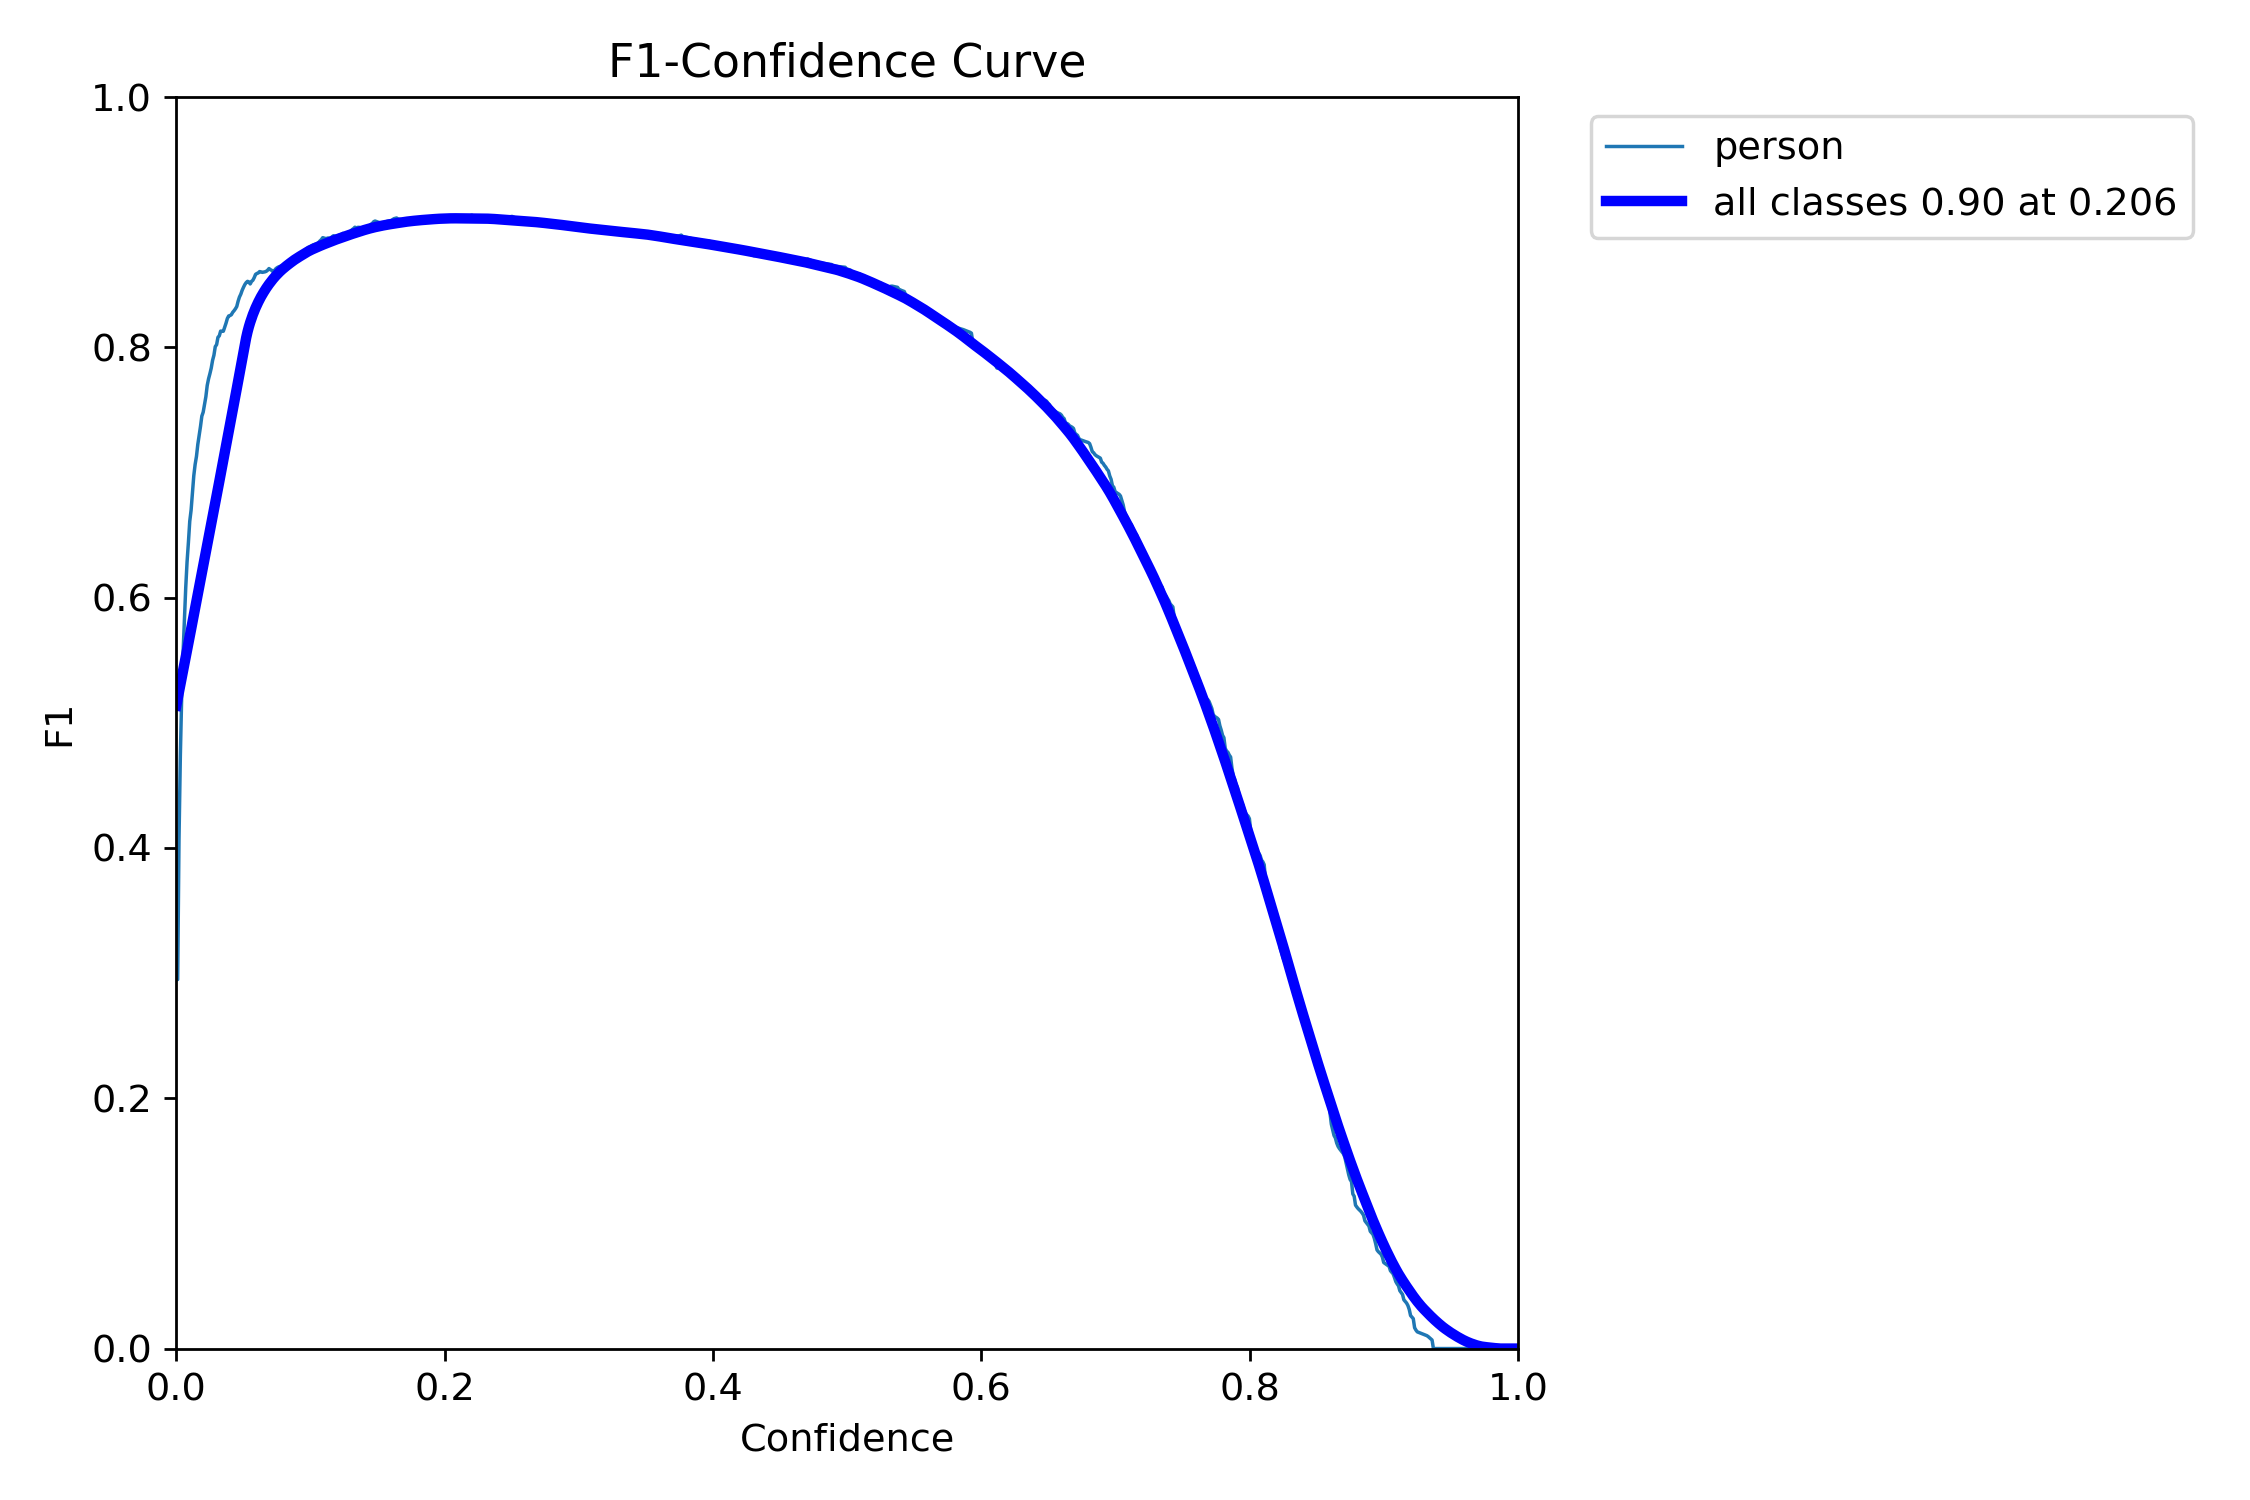

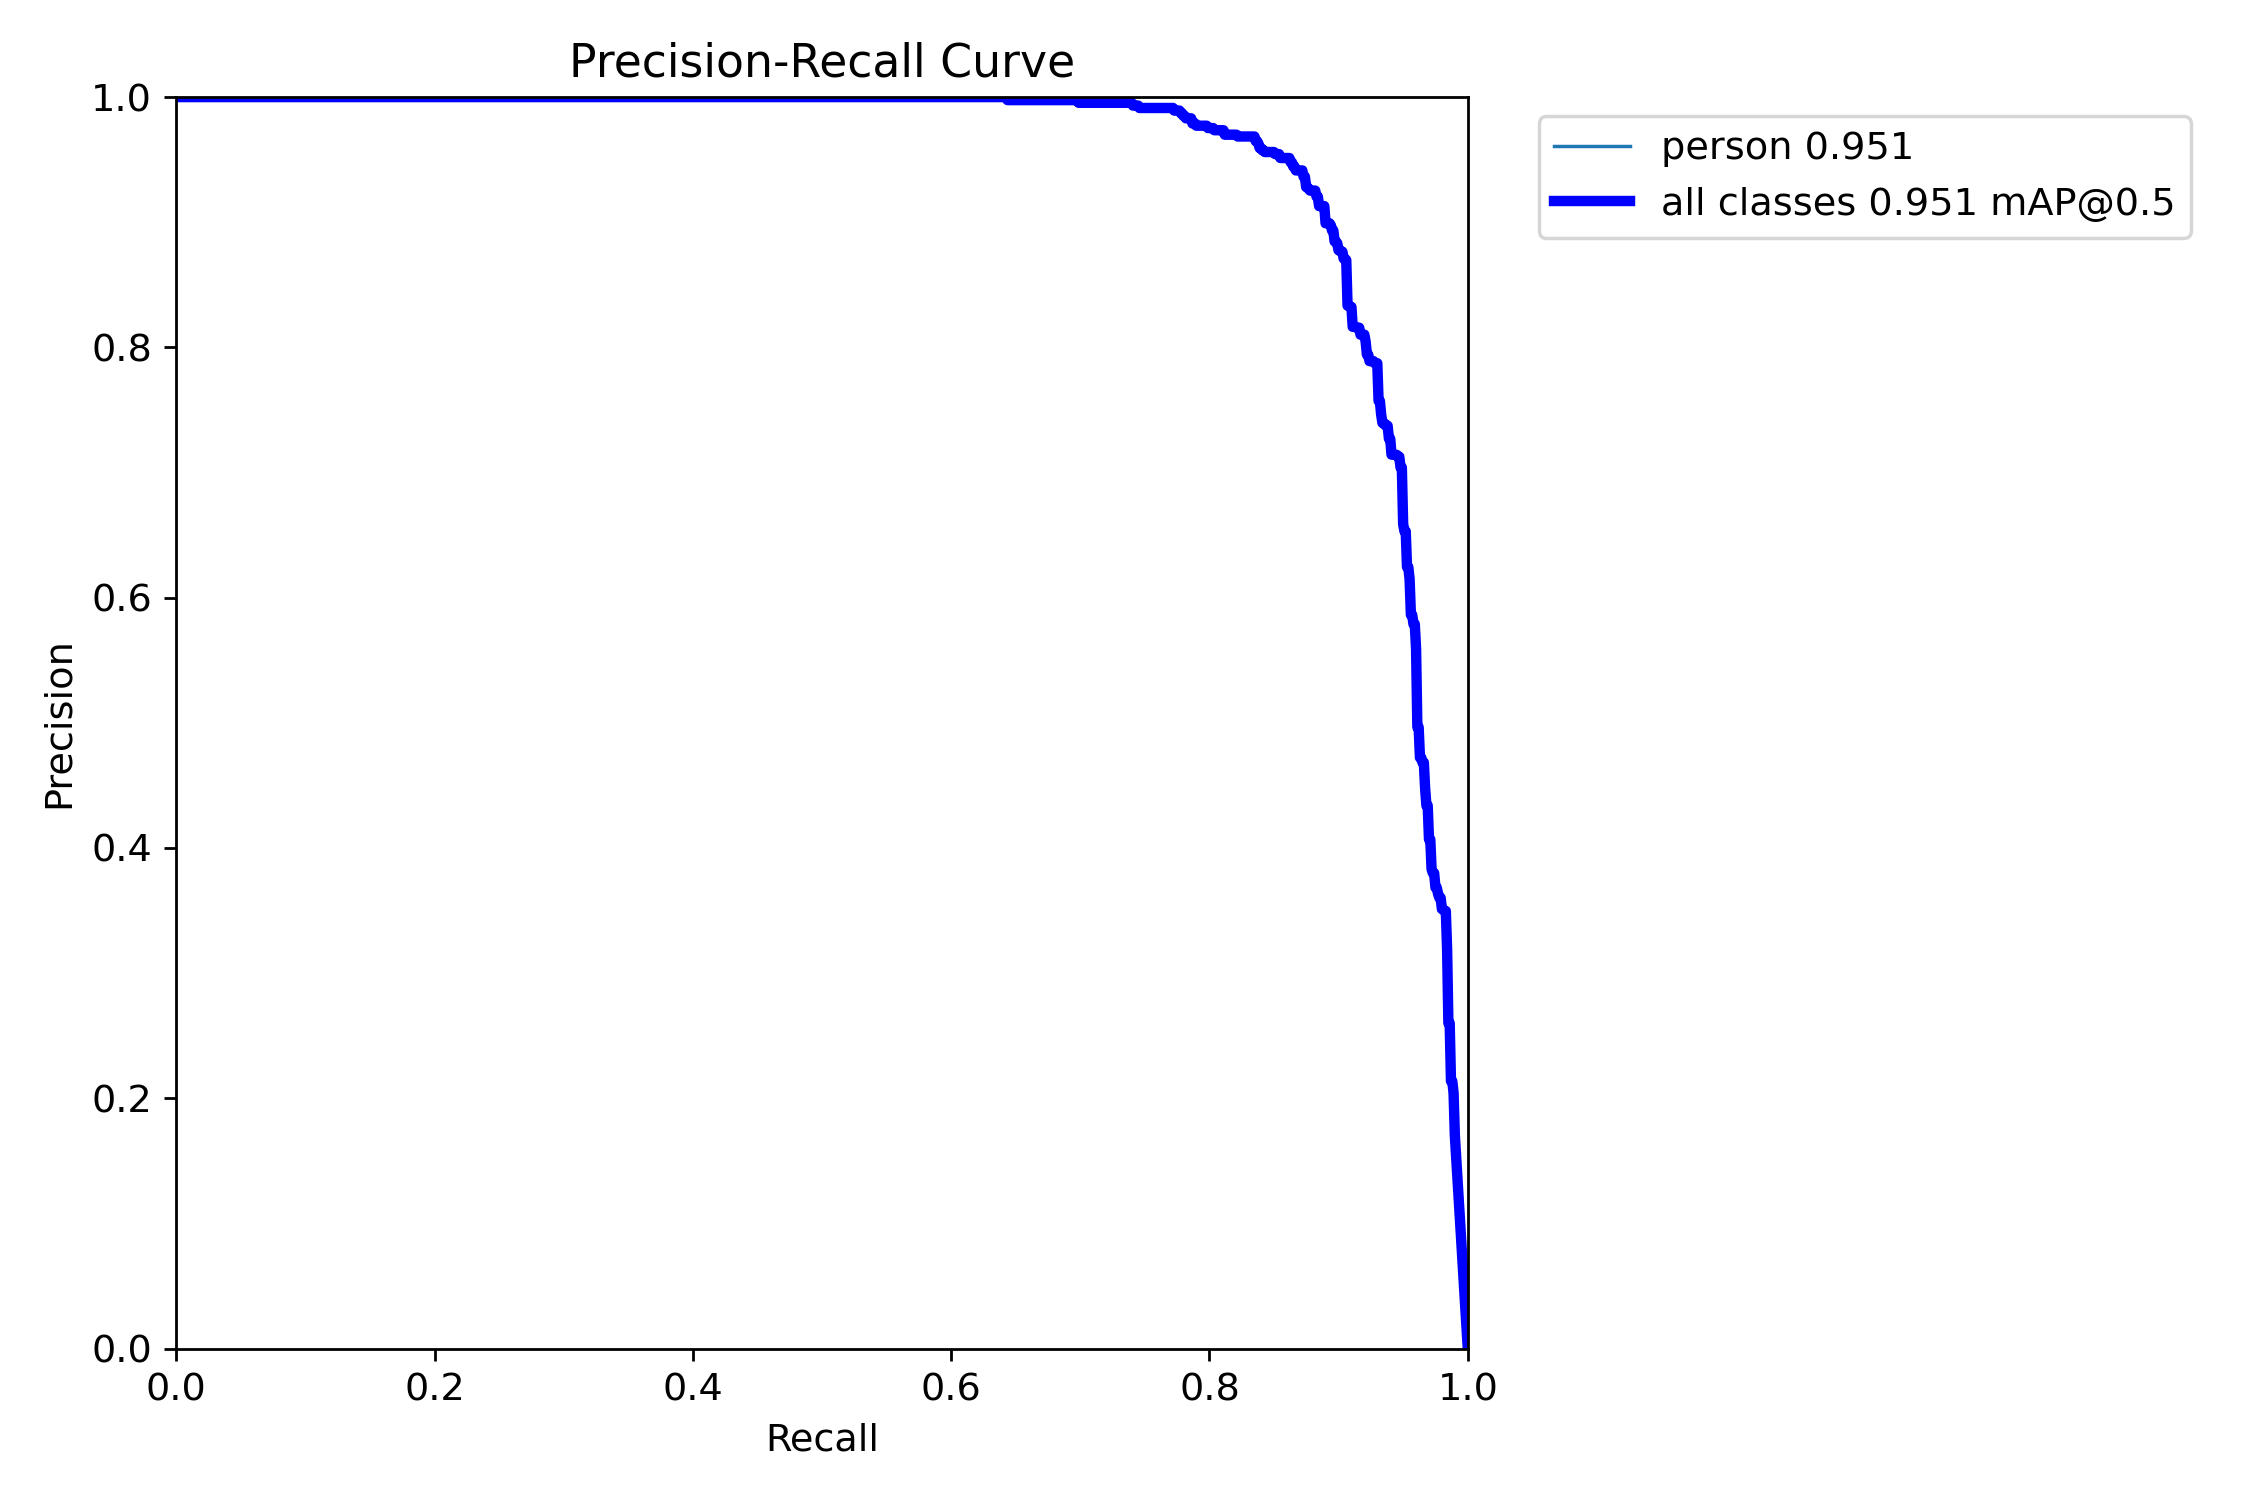

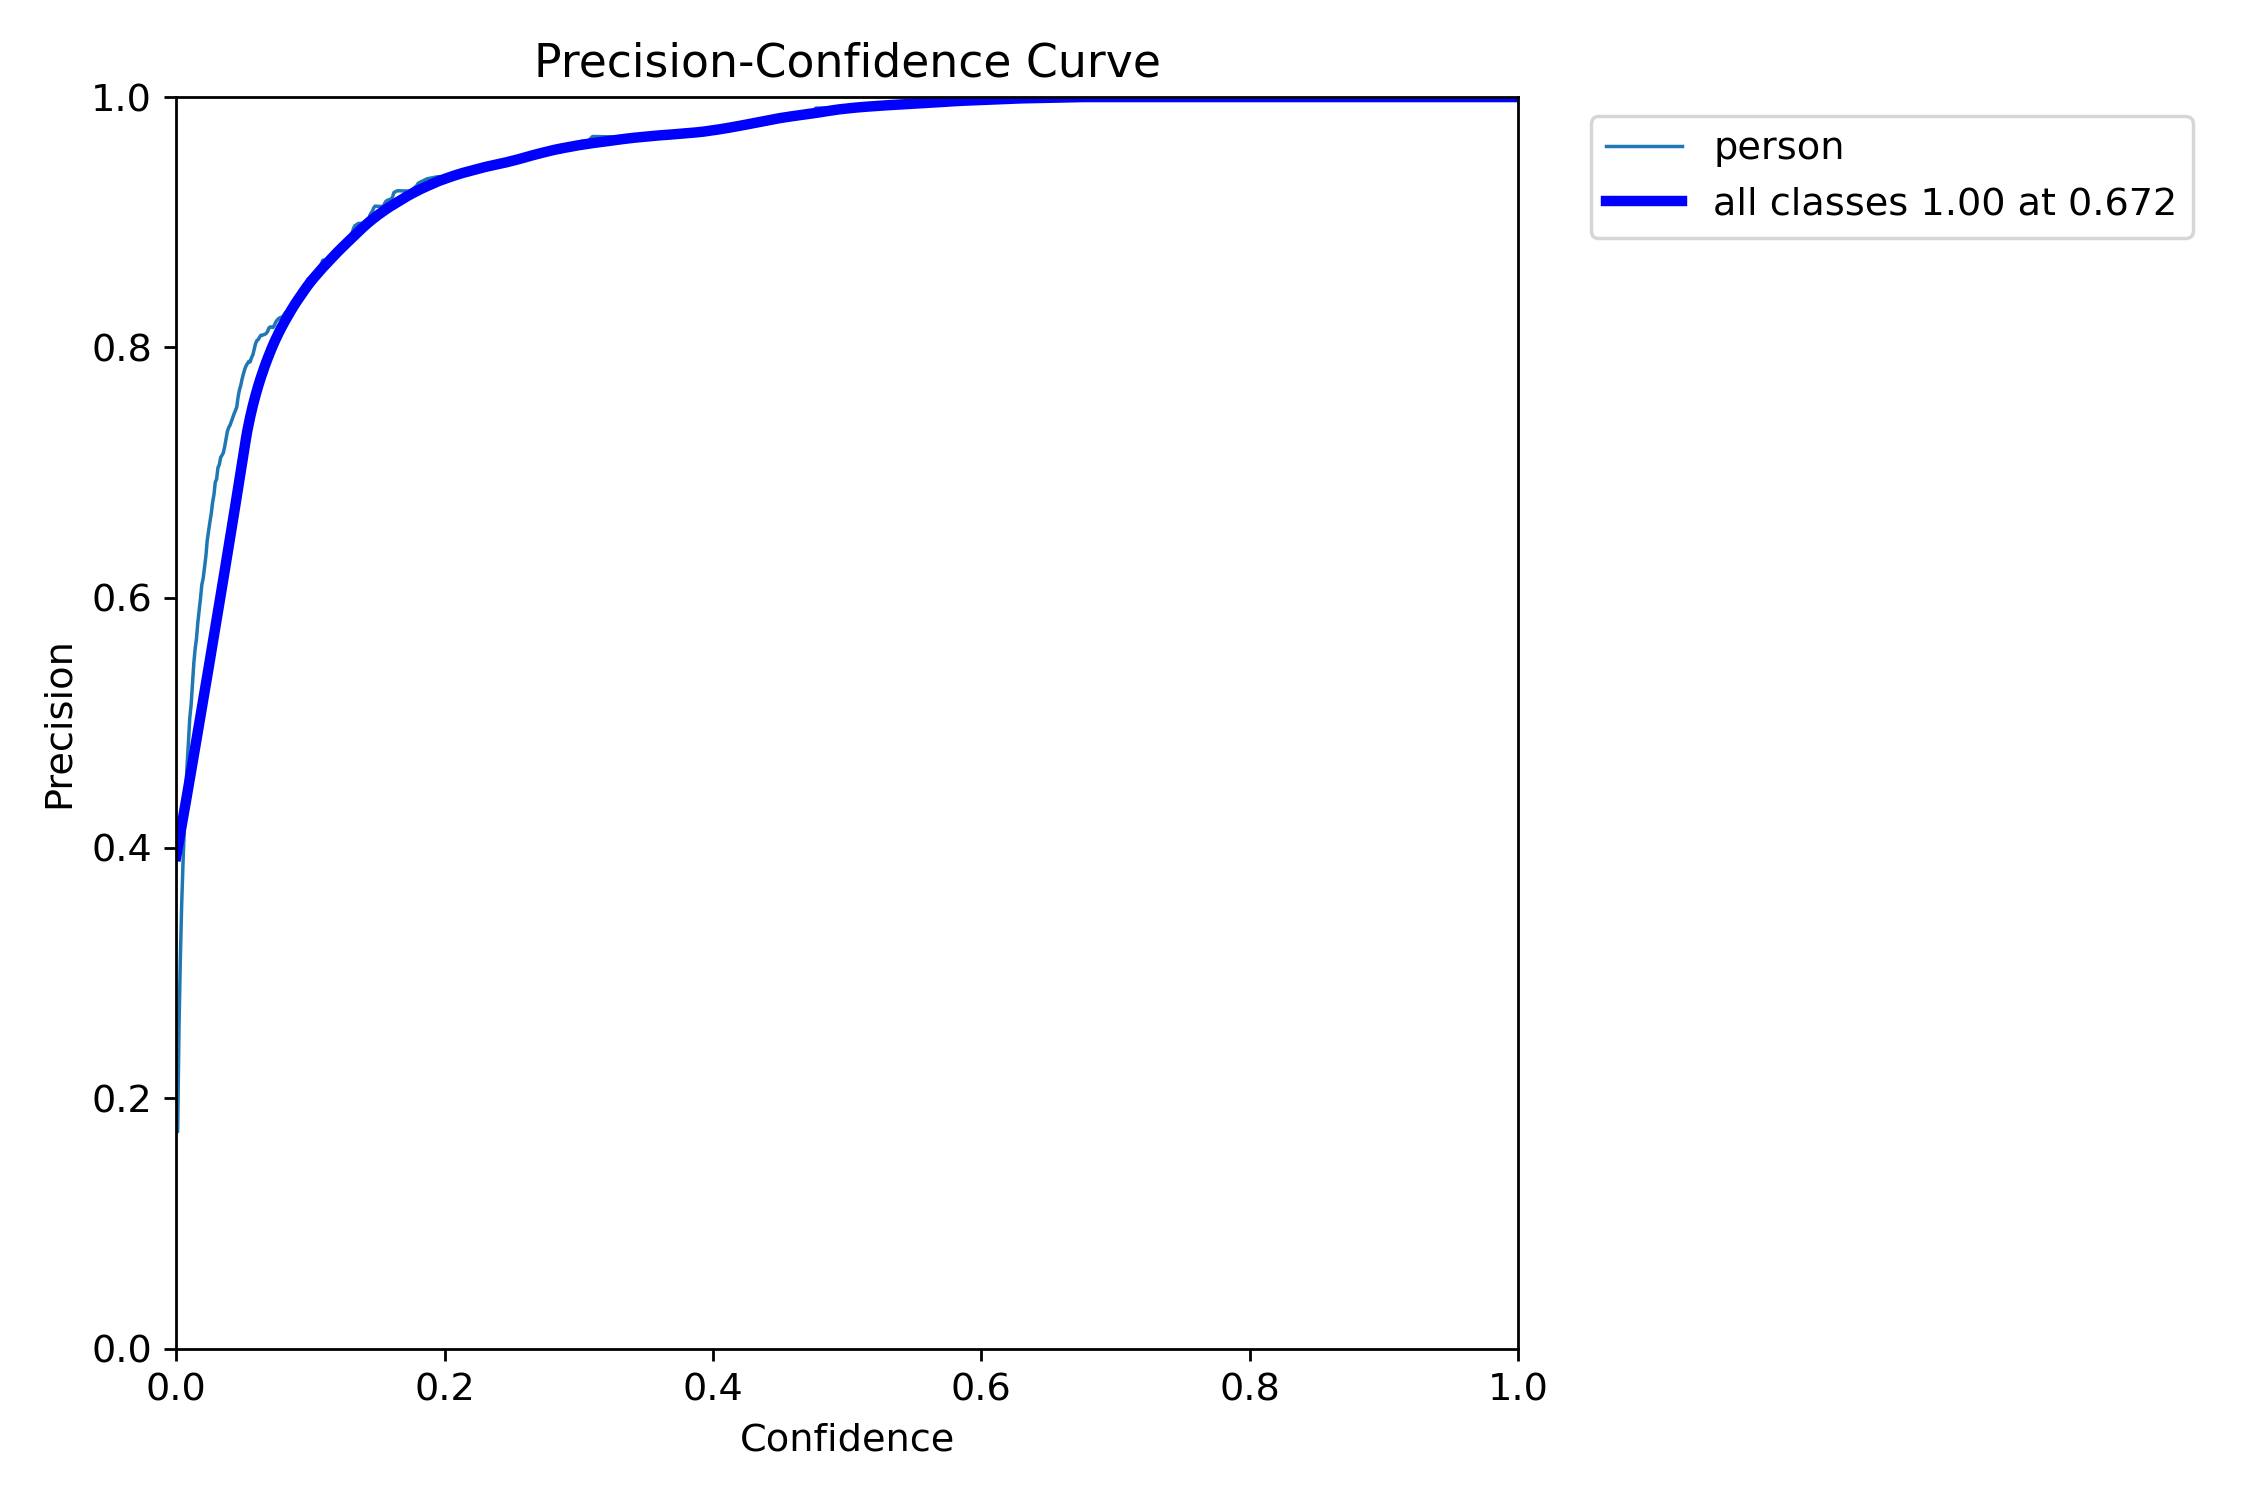

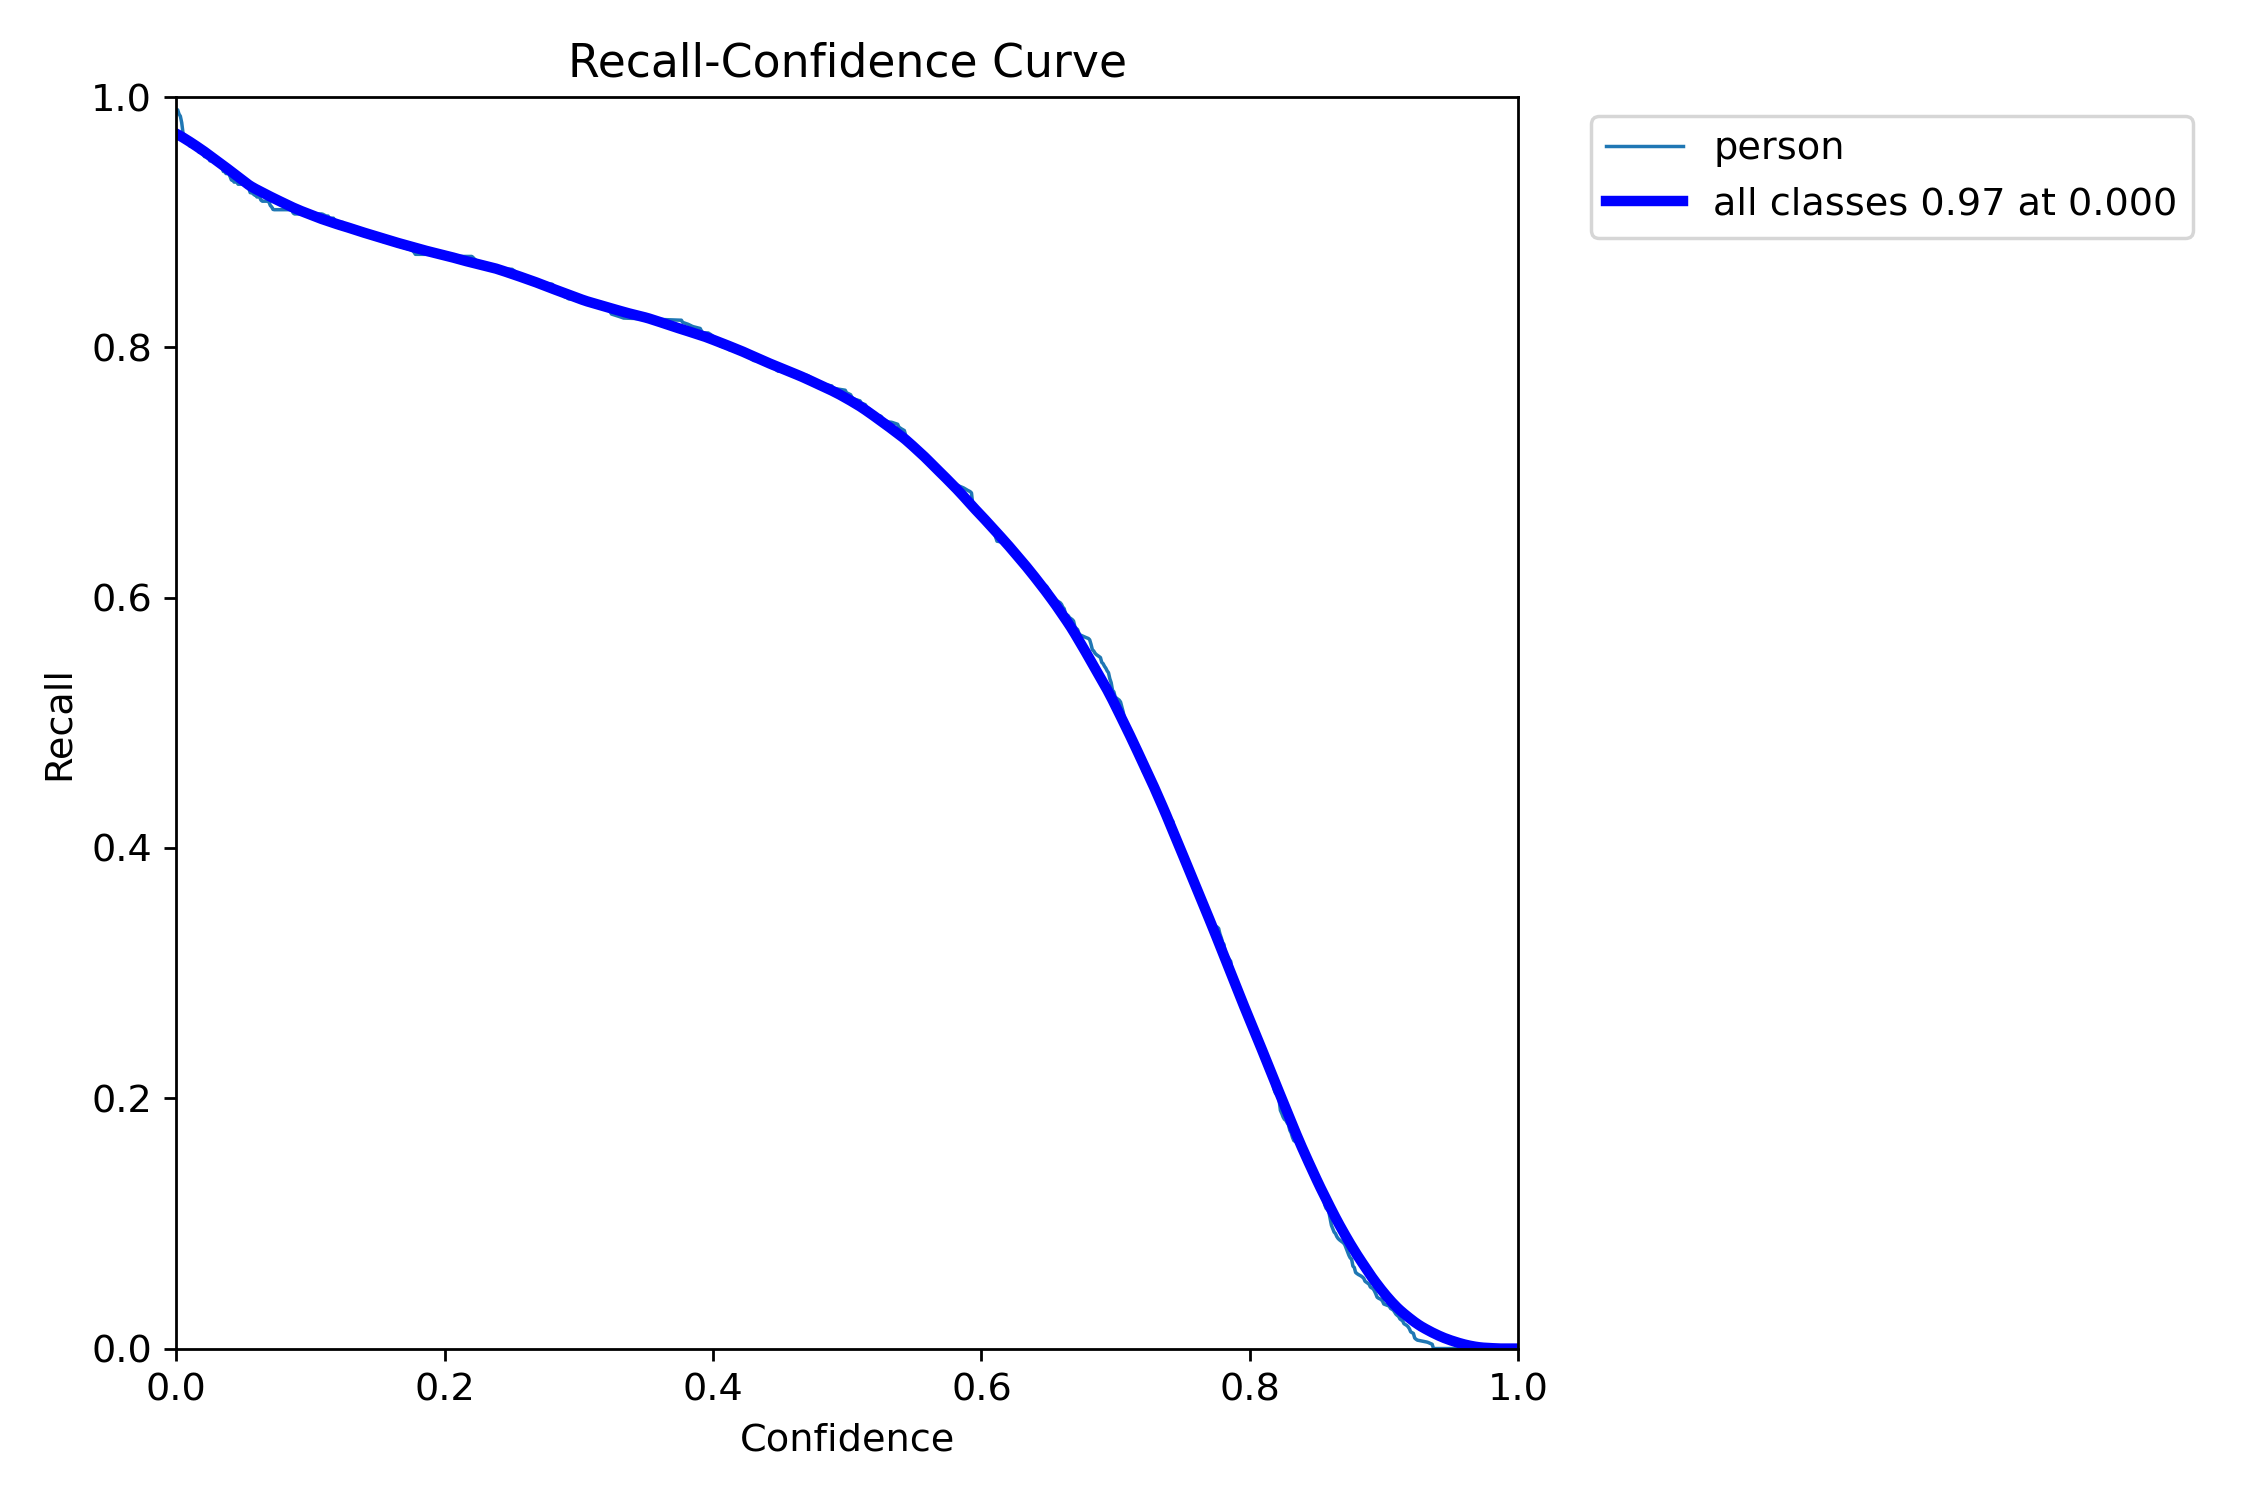

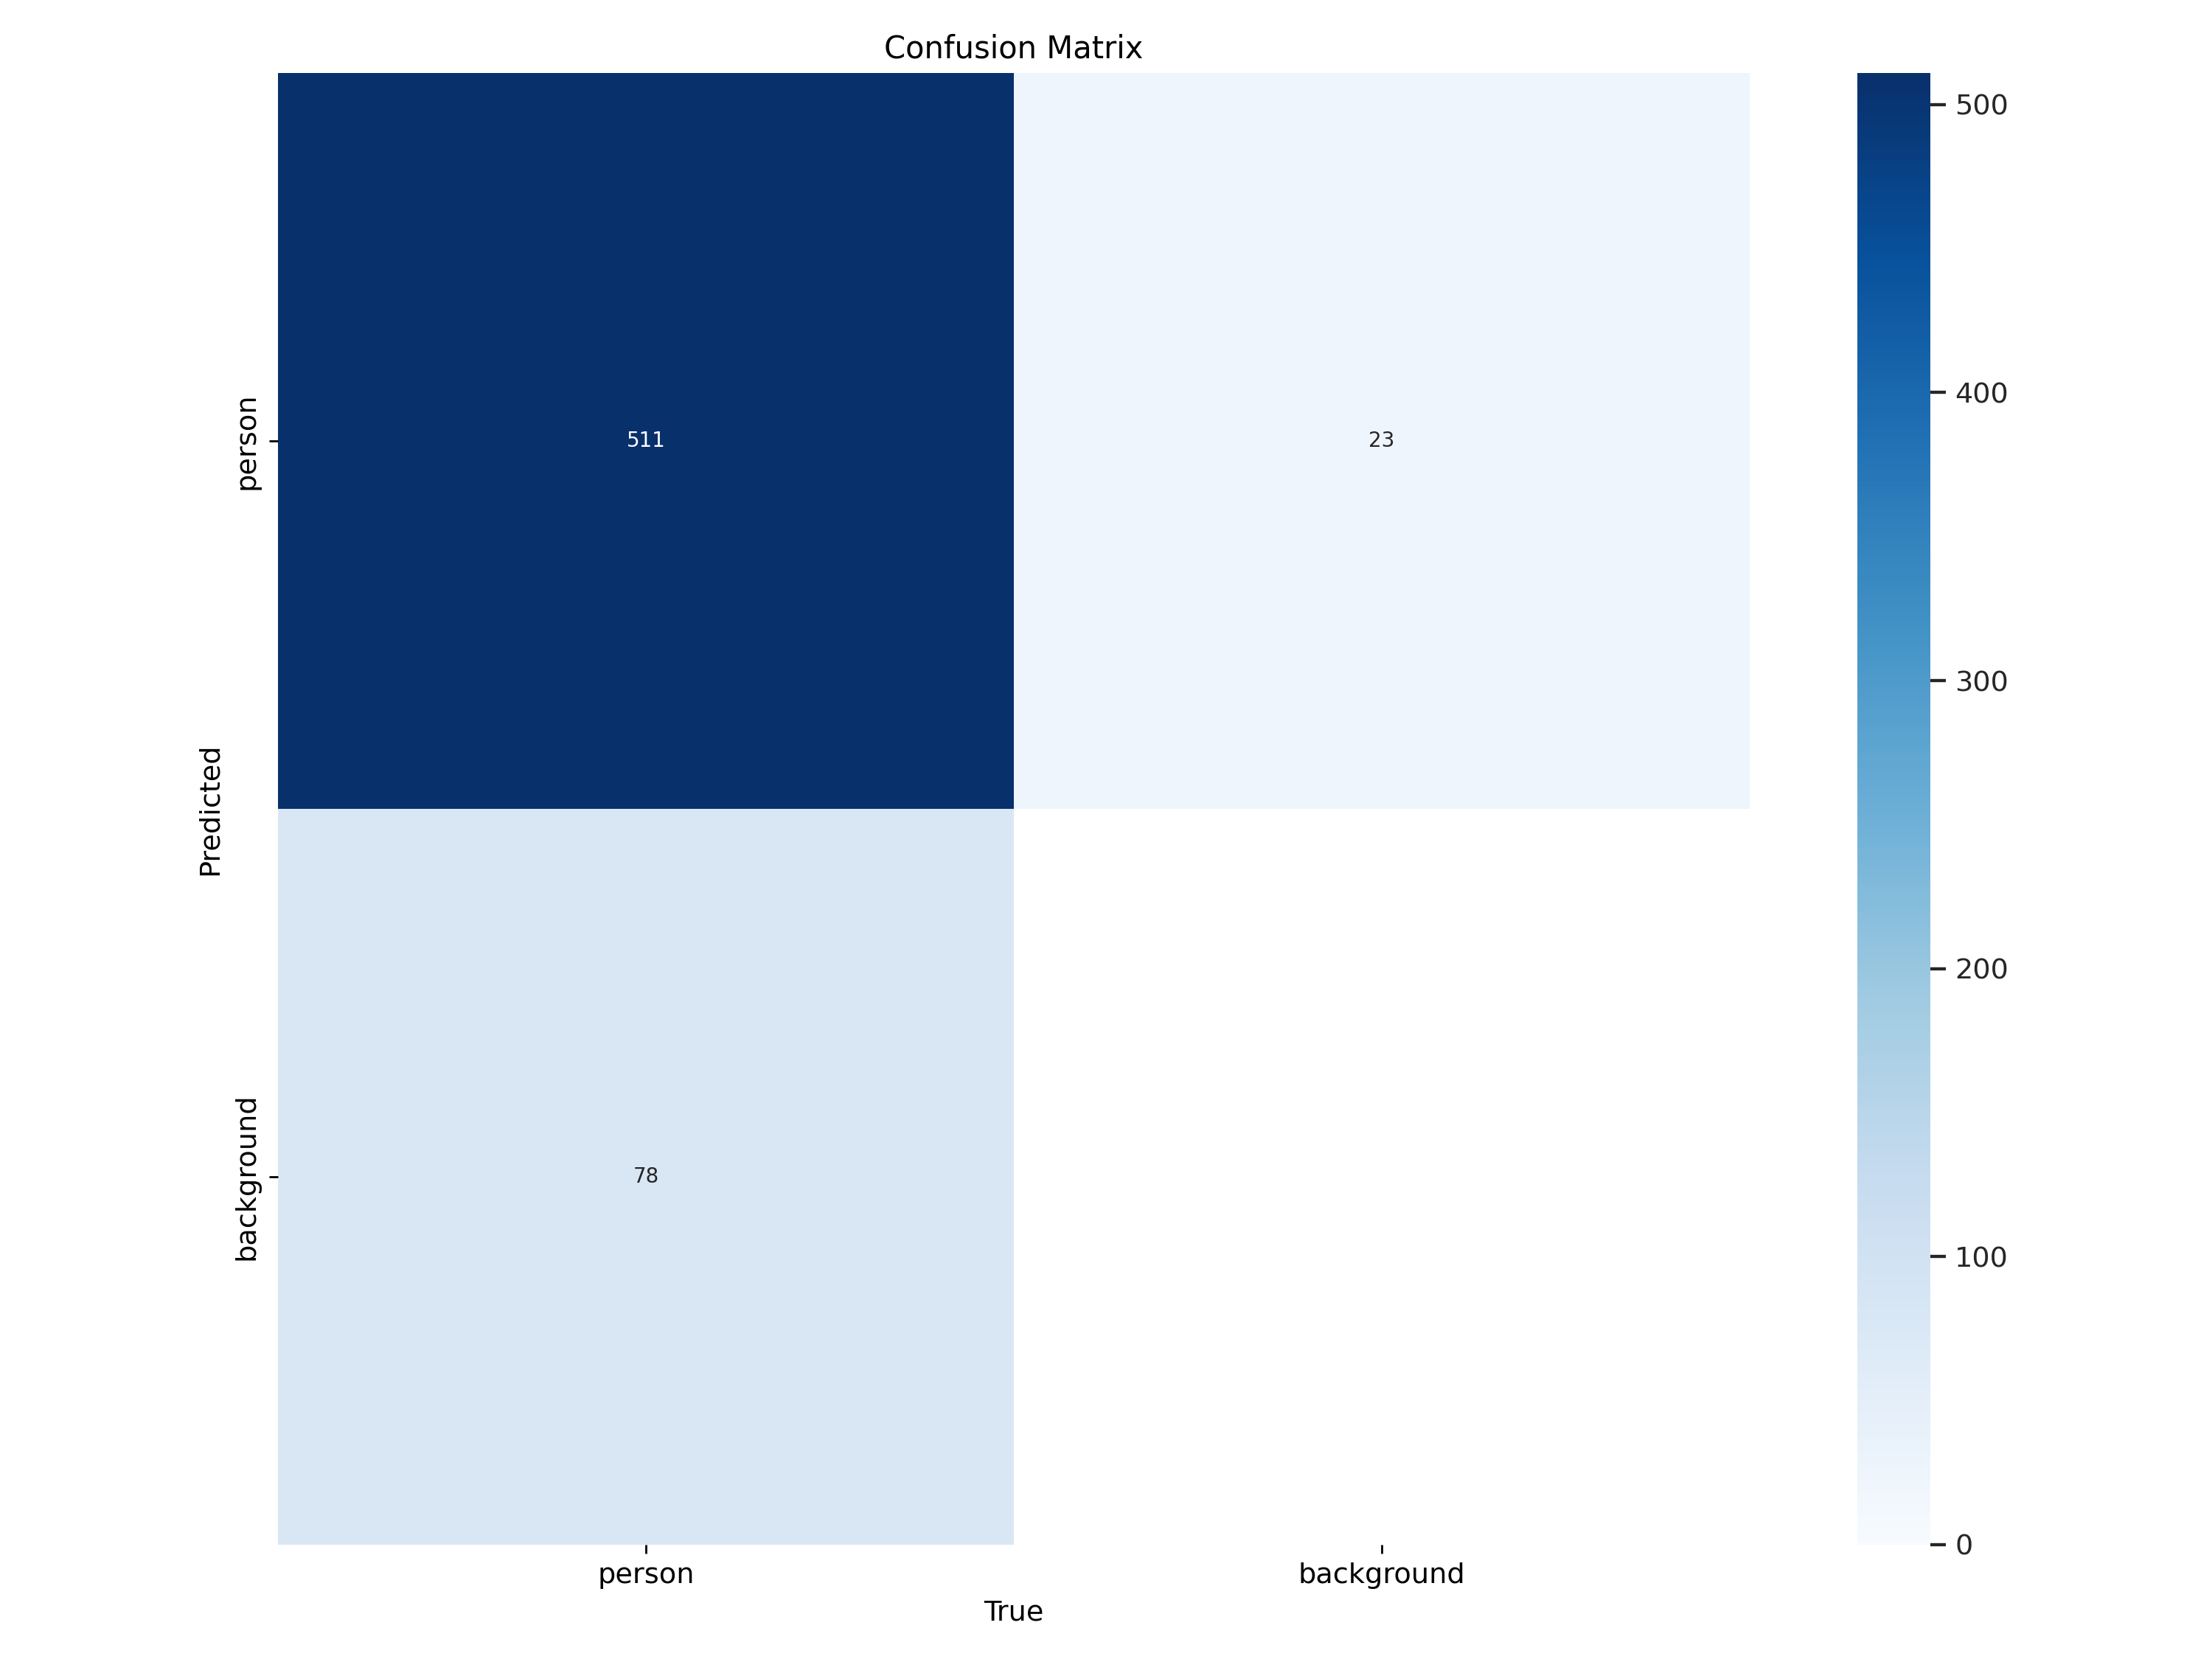

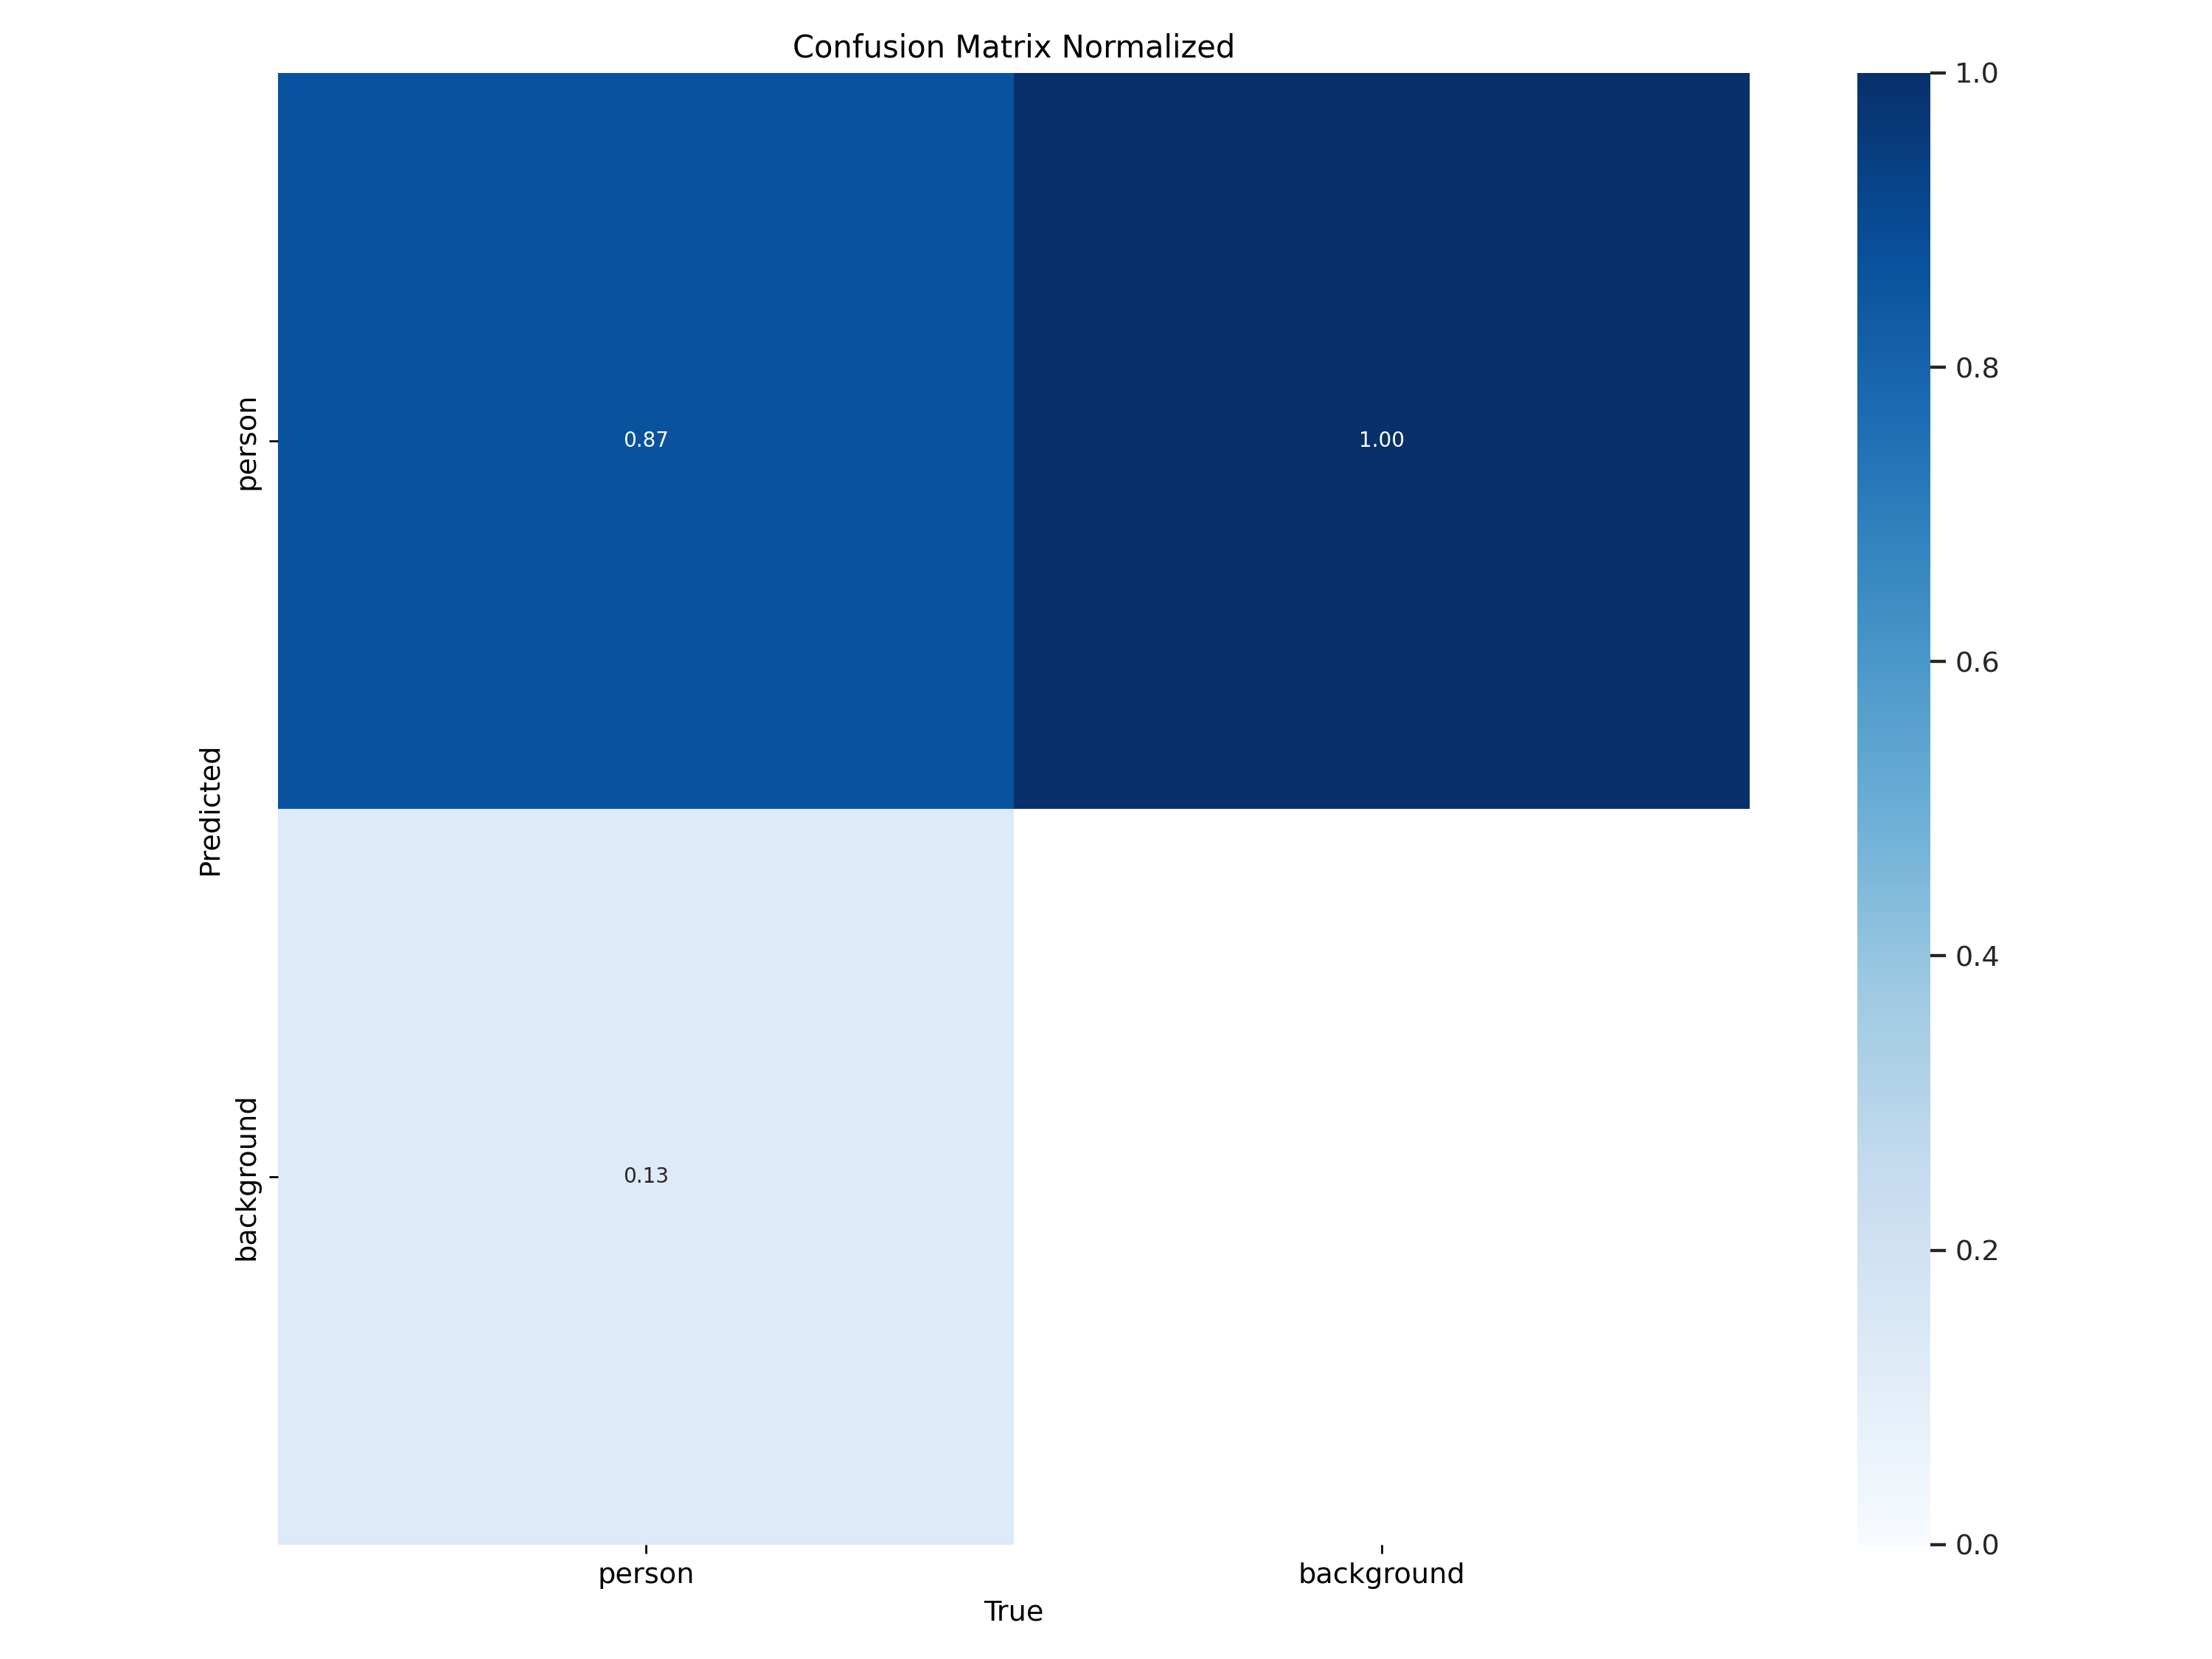

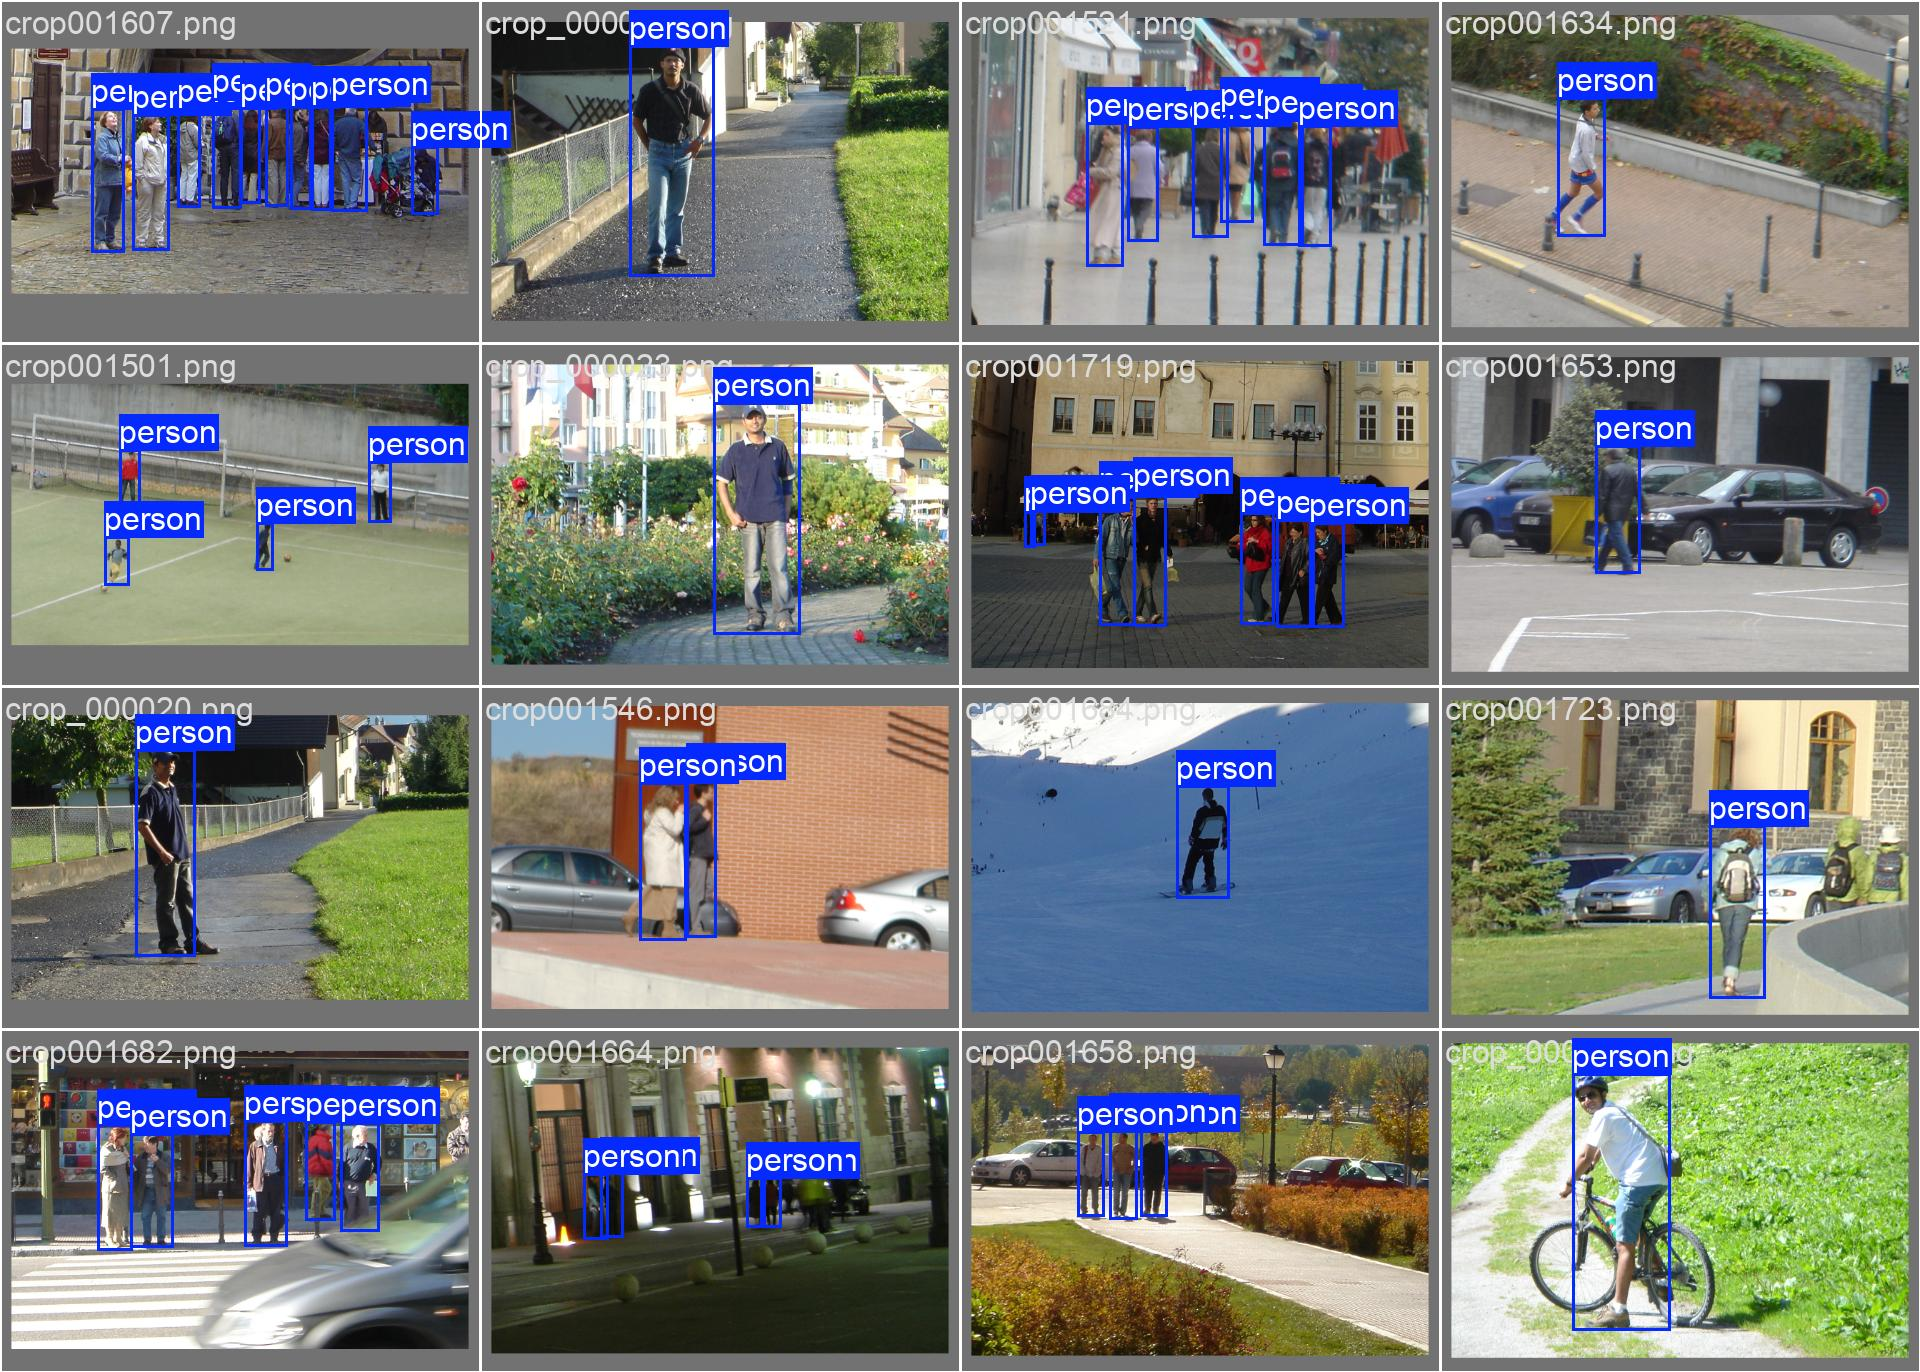

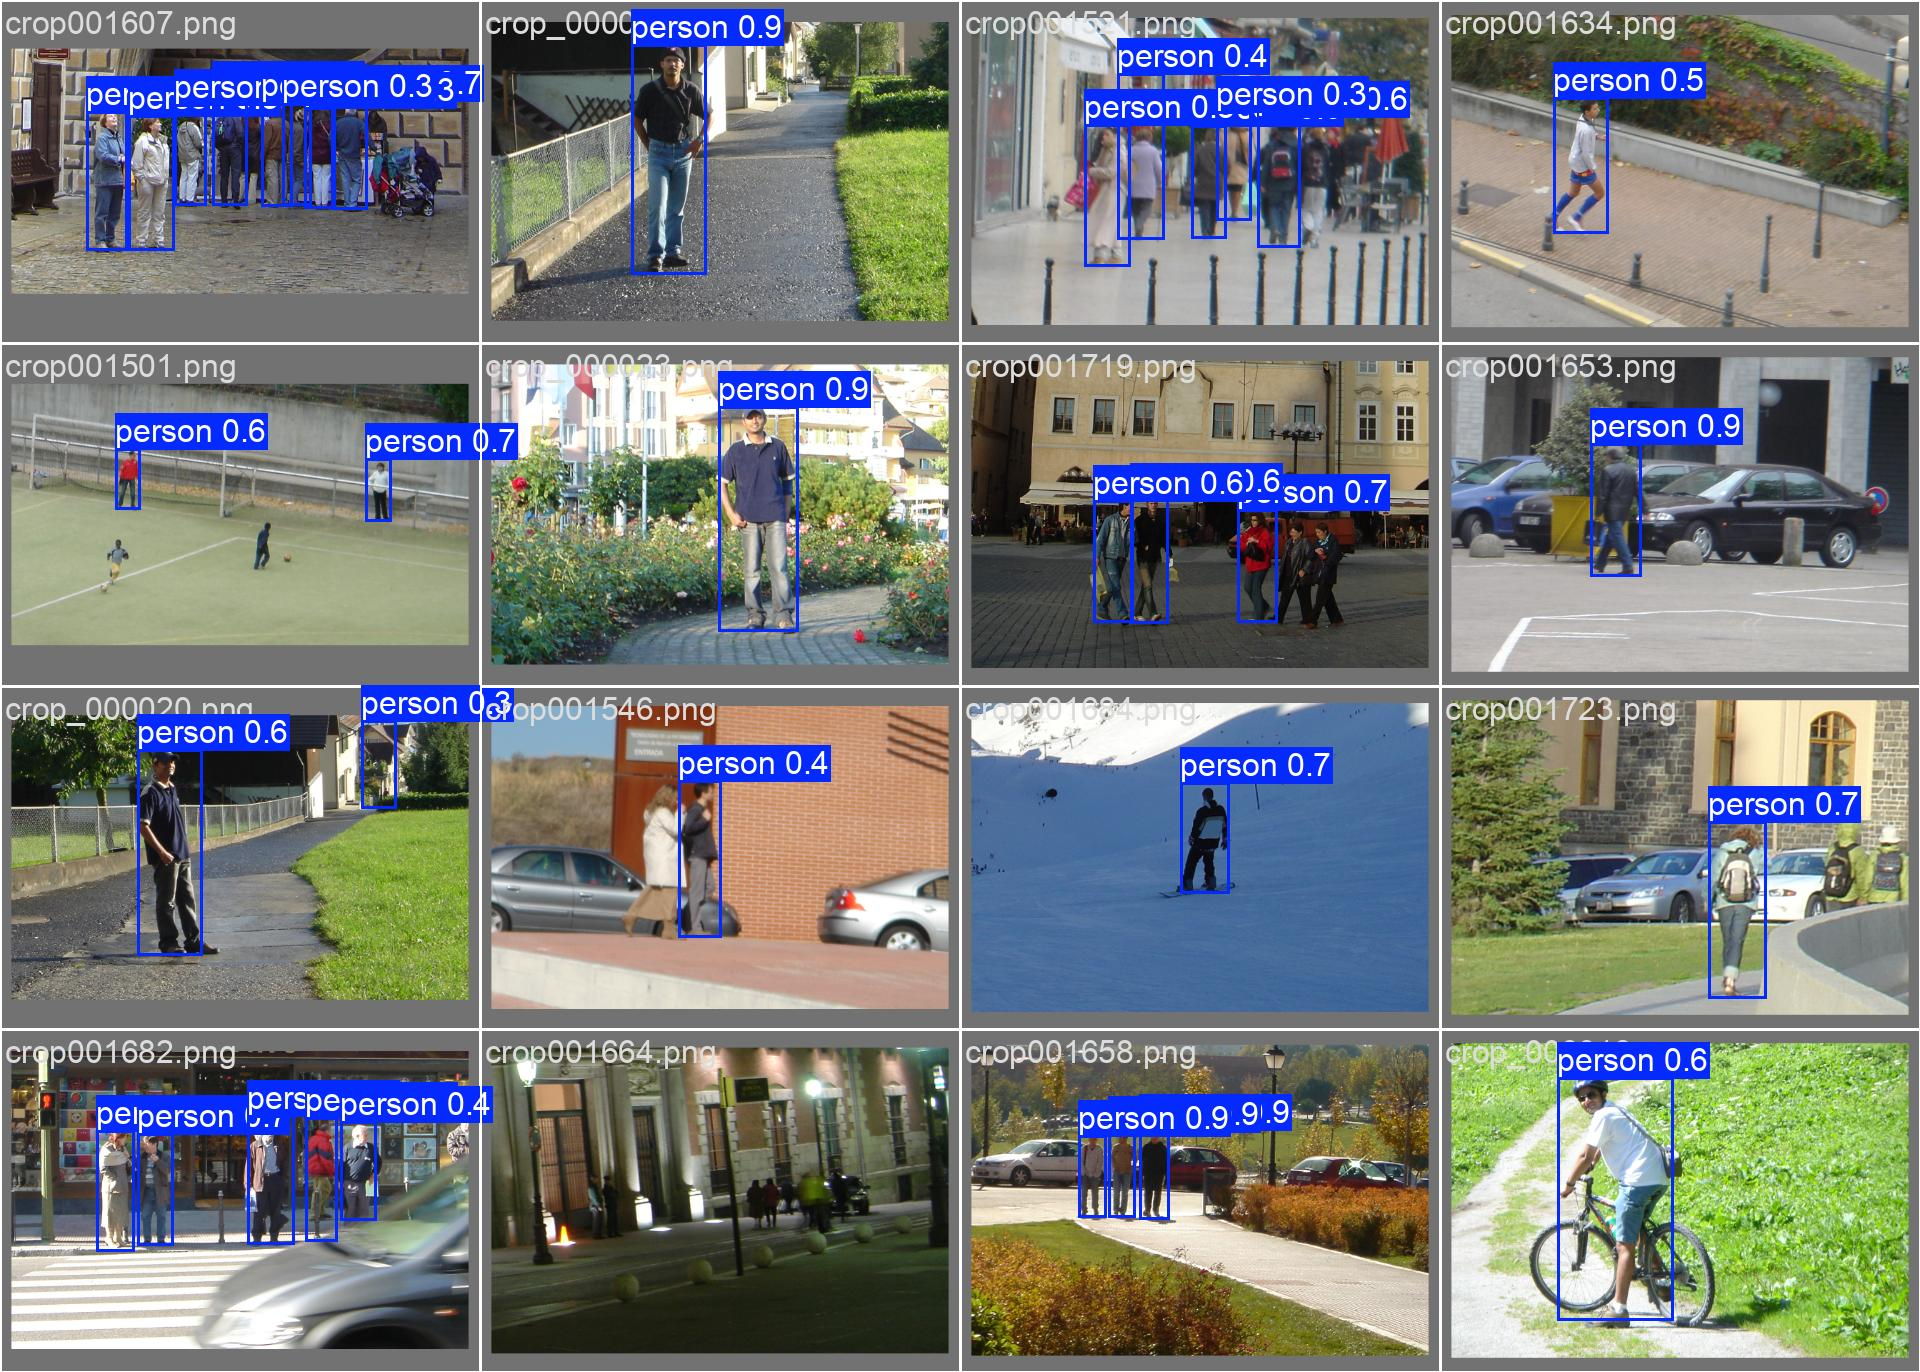

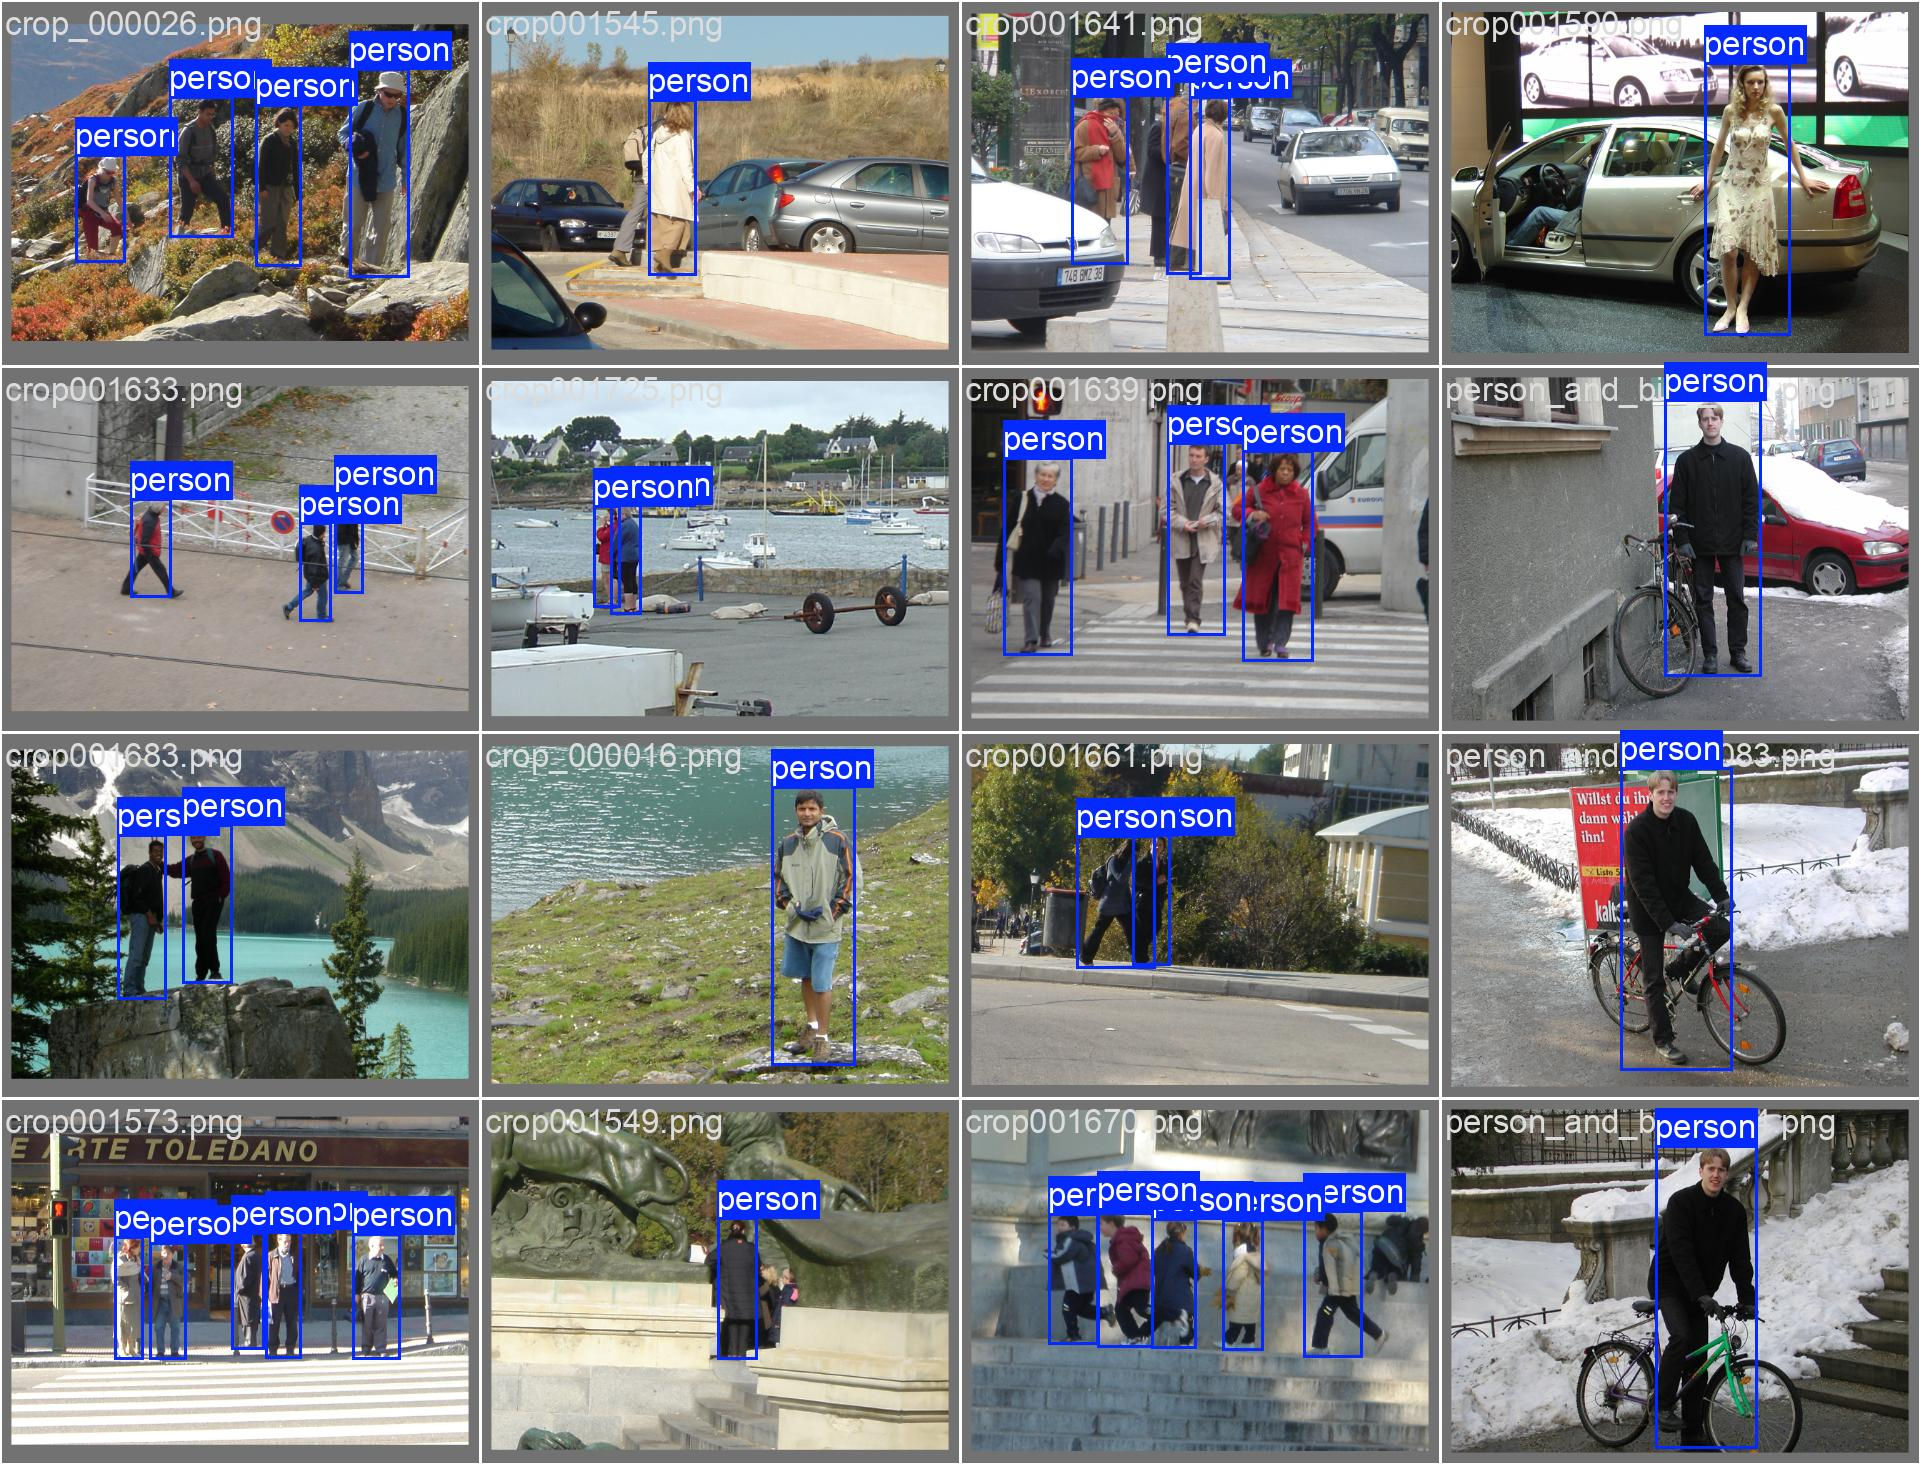

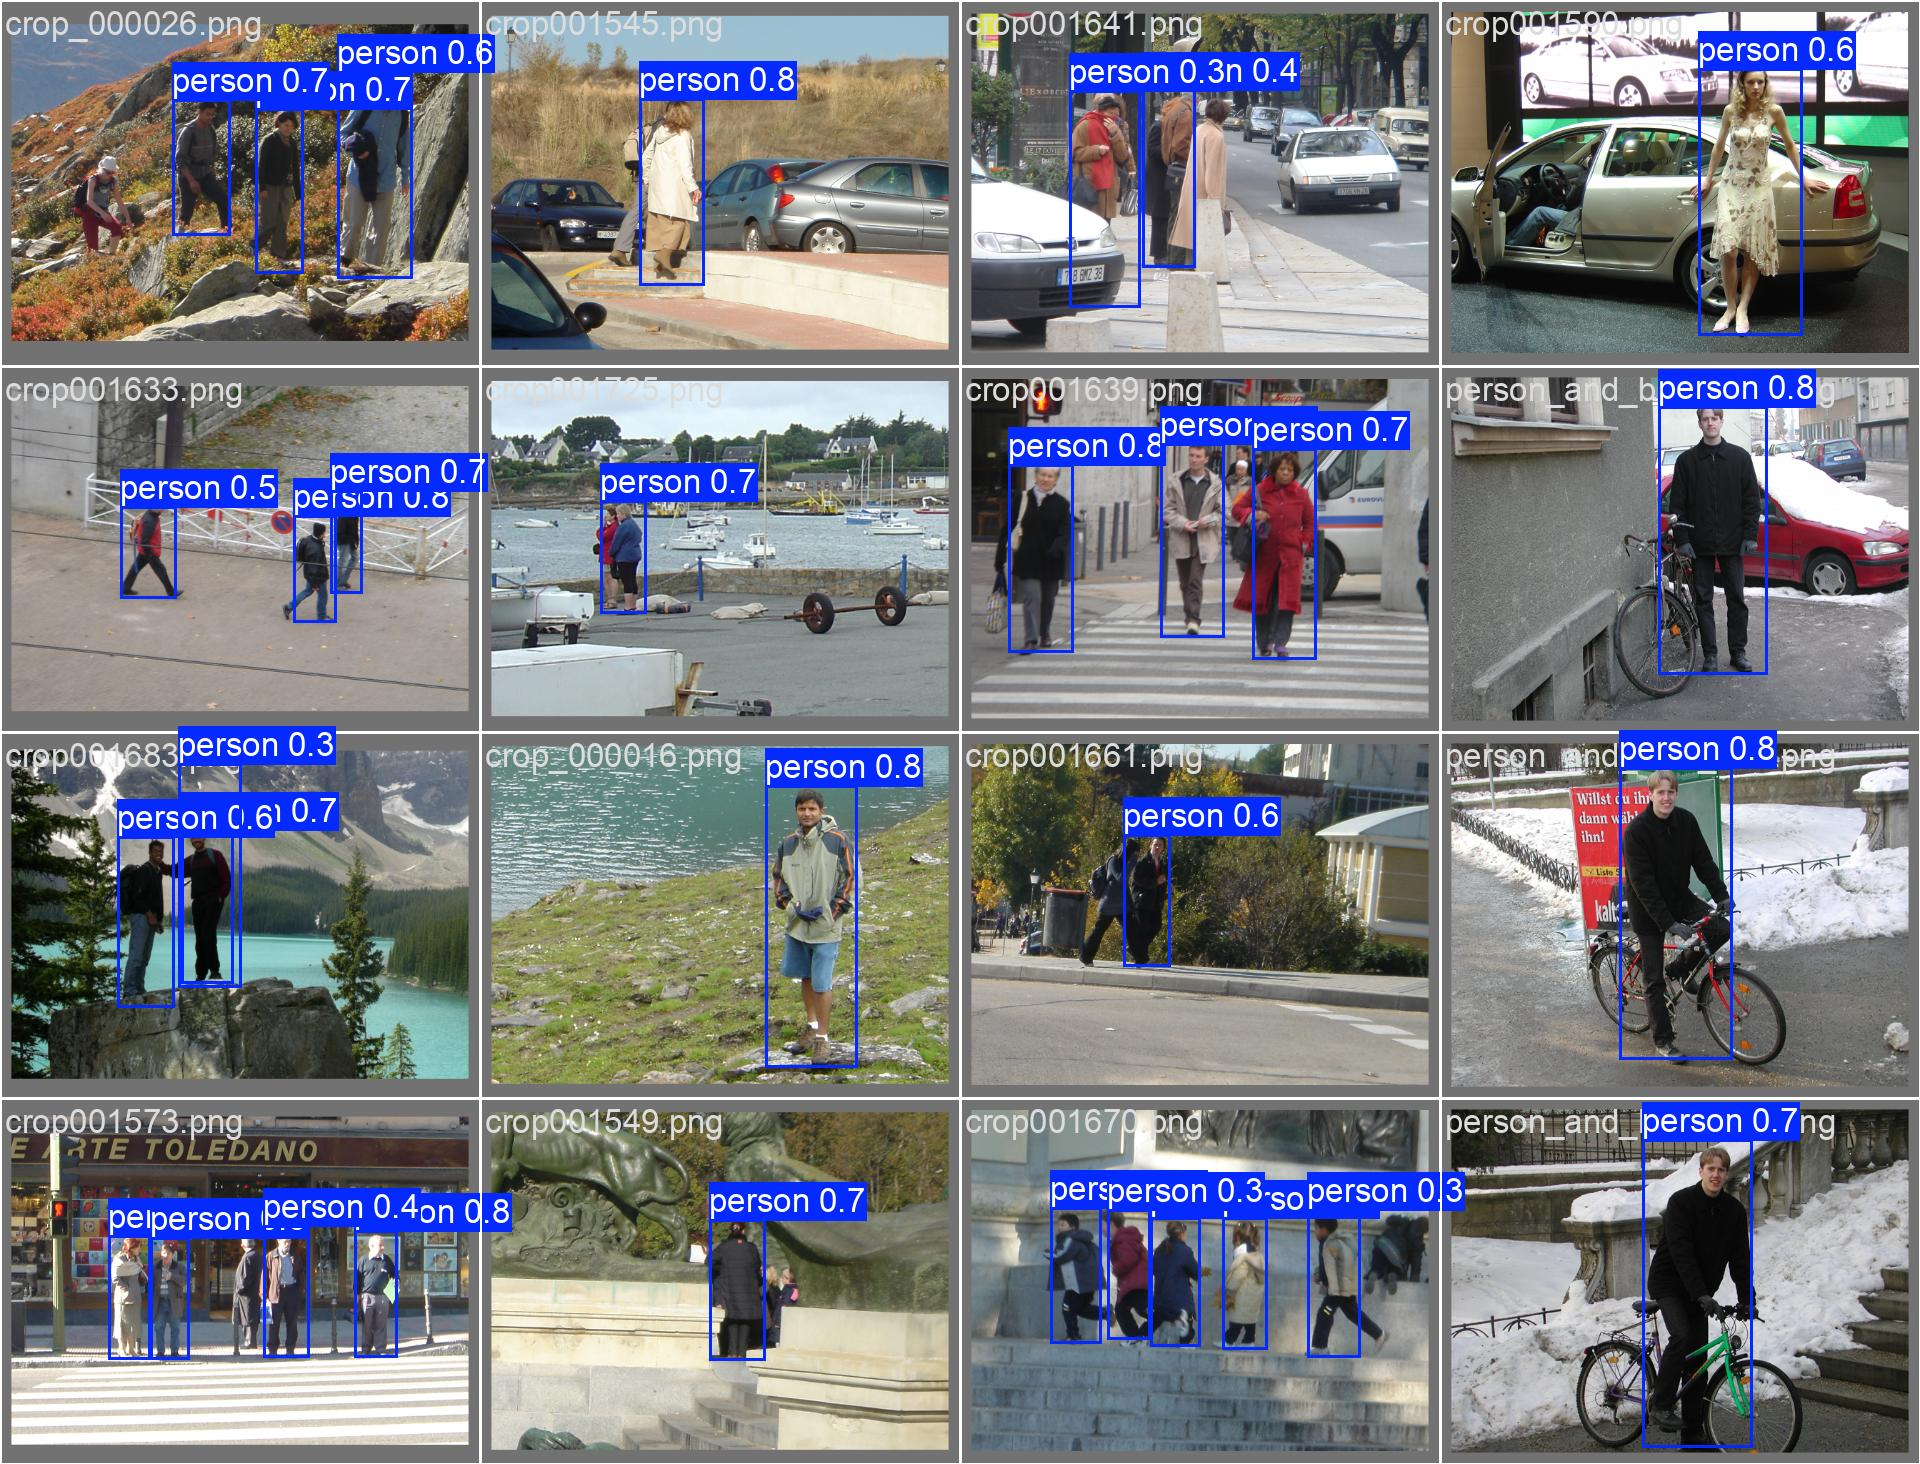

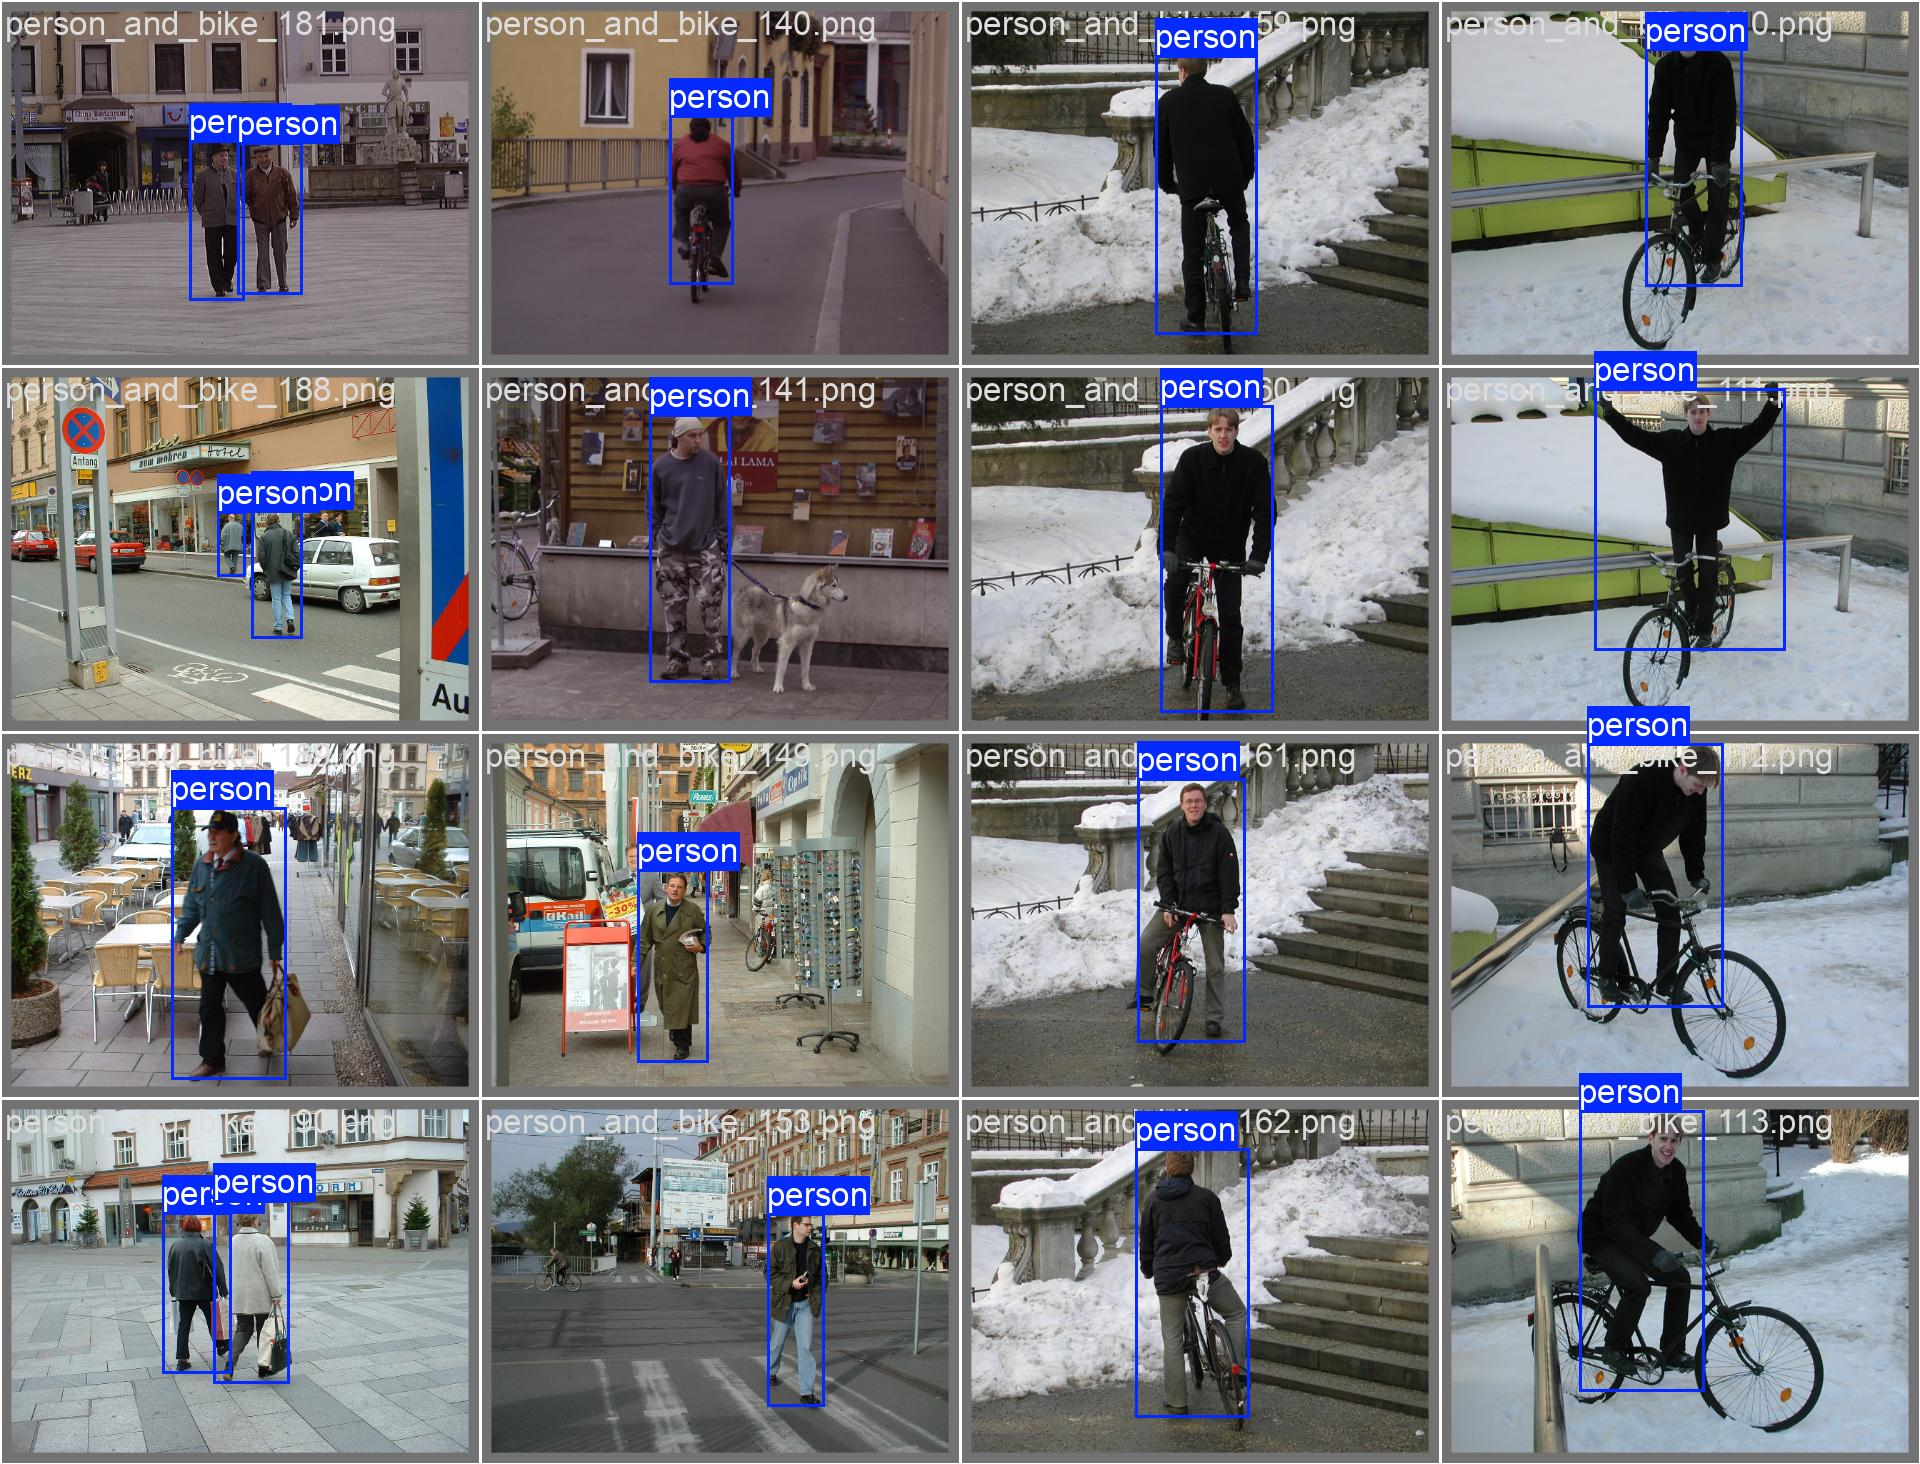

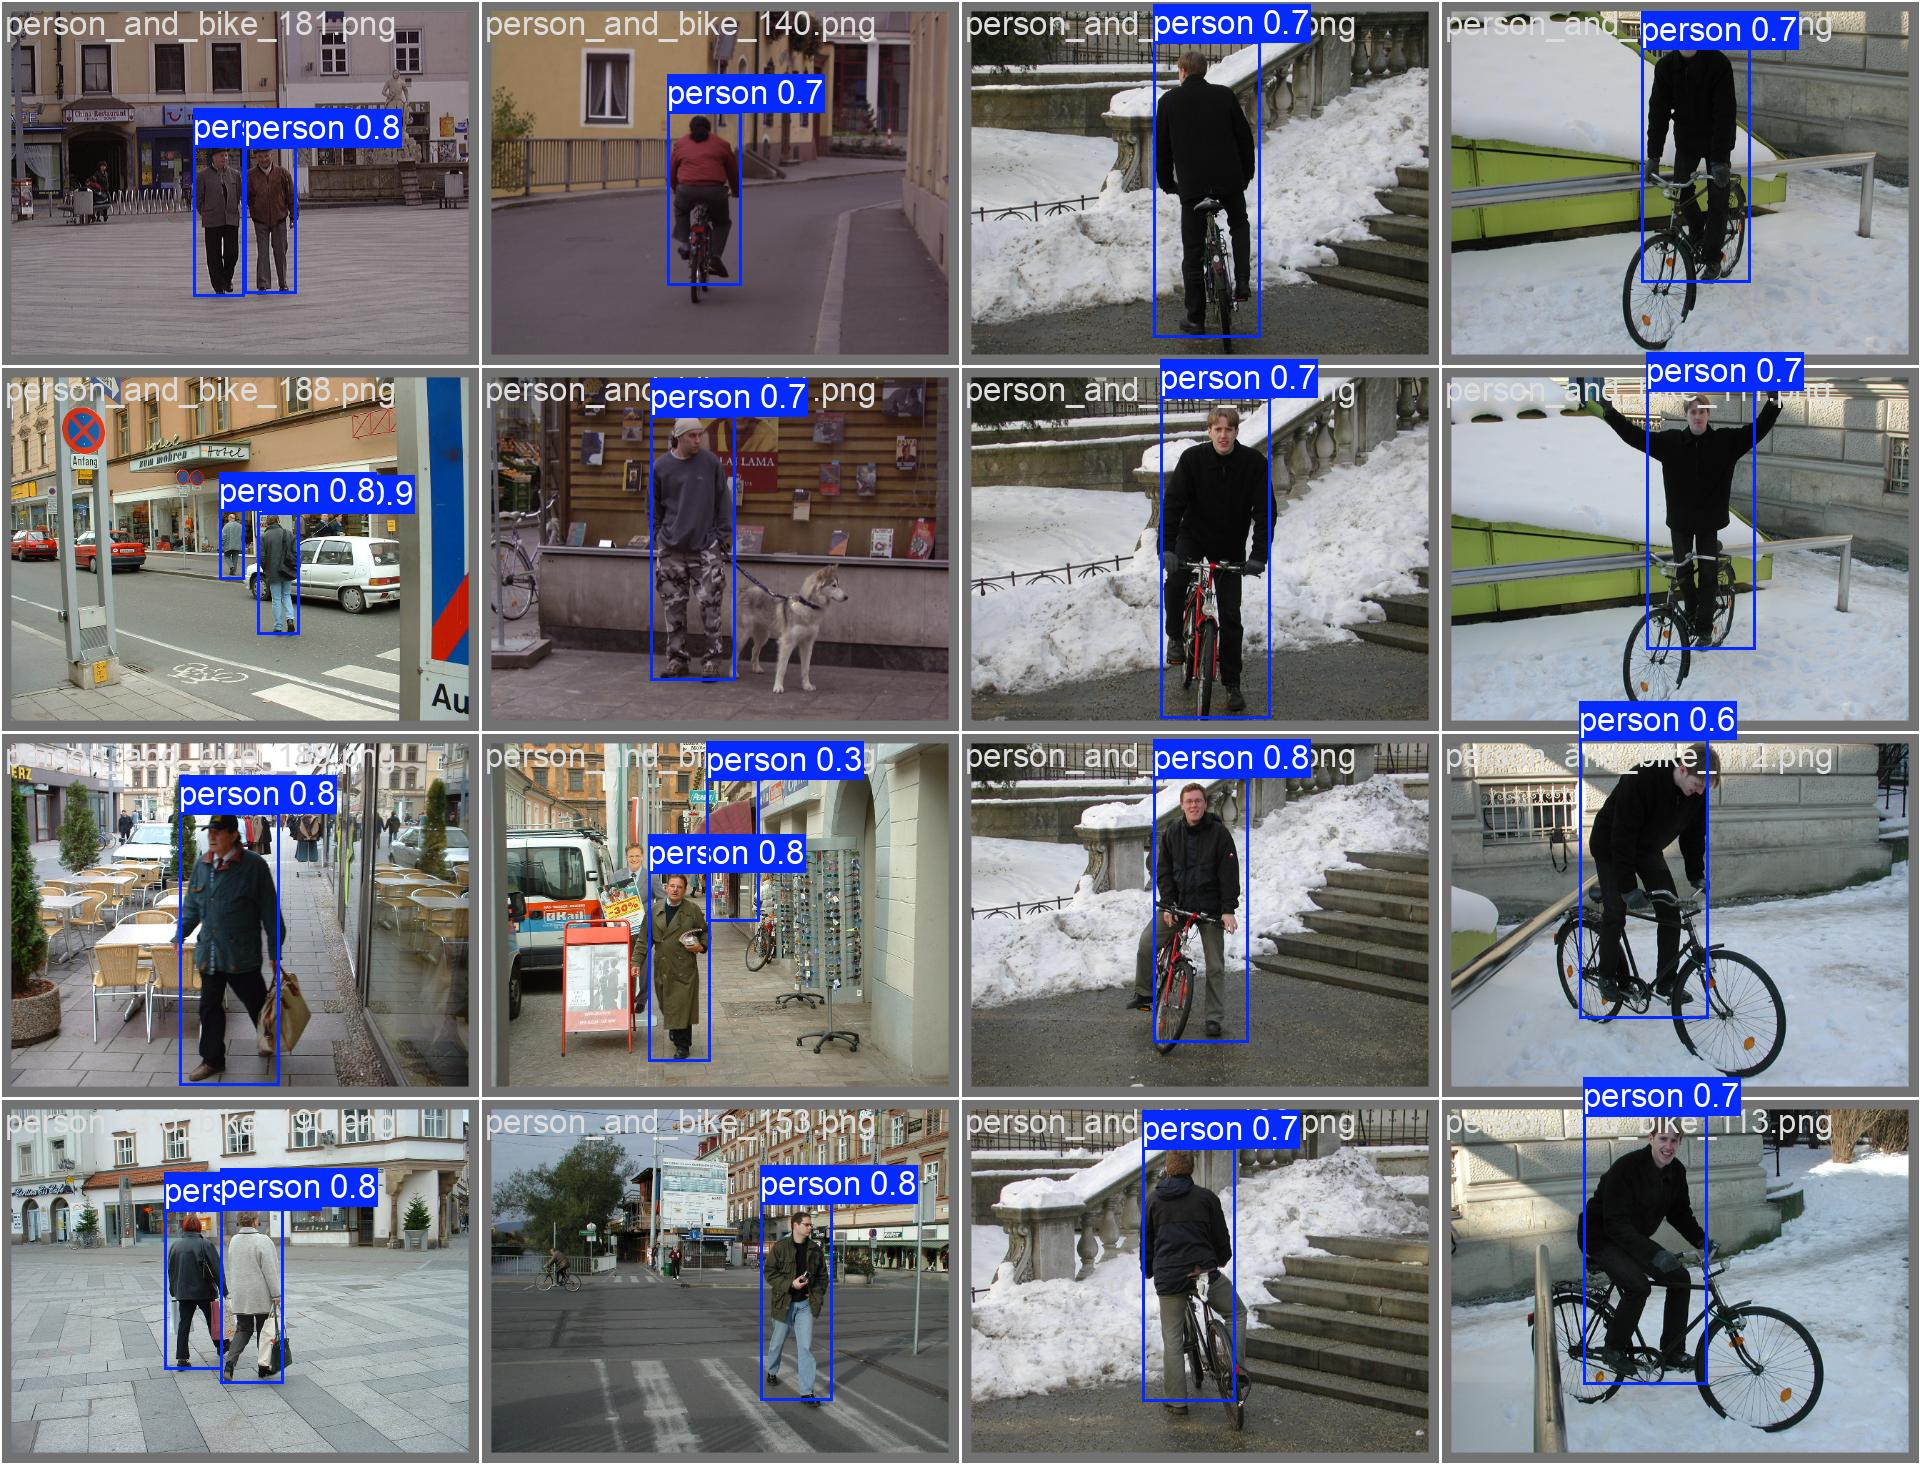

In [23]:
import os
from IPython.display import Image, display

# Directory containing YOLOv8 output images
val_dir = "/content/runs/detect/val3"

# List and display all image files
for file_name in sorted(os.listdir(val_dir)):
    if file_name.lower().endswith(('.jpg', '.png')):
        display(Image(filename=os.path.join(val_dir, file_name)))
